## **IMPORT LIBRARIES**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import cv2
import os
from imutils import paths
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD

from tensorflow.keras import backend as K

from imblearn.over_sampling import SMOTE 

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 13576958417400128638
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11320098816
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 17270889526896283433
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
 xla_global_id: 416903419]

In [ ]:
!nvidia-smi -q


==============NVSMI LOG==============

Timestamp                                 : Wed Mar  2 01:05:39 2022
Driver Version                            : 460.32.03
CUDA Version                              : 11.2

Attached GPUs                             : 1
GPU 00000000:00:04.0
    Product Name                          : Tesla K80
    Product Brand                         : Tesla
    Display Mode                          : Disabled
    Display Active                        : Disabled
    Persistence Mode                      : Disabled
    MIG Mode
        Current                           : N/A
        Pending                           : N/A
    Accounting Mode                       : Disabled
    Accounting Mode Buffer Size           : 4000
    Driver Model
        Current                           : N/A
        Pending                           : N/A
    Serial Number                         : 0320617086409
    GPU UUID                              : GPU-9f37a96e-cbe1-5733-2c32-40b

In [ ]:
!nvidia-smi

Wed Mar  2 01:05:42 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P0    73W / 149W |    145MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## **DATA LOADING**

In [ ]:
def load(paths, verbose=-1):
    '''expects images for each class in seperate dir, 
    e.g all digits in 0 class in the directory named 0 '''
    data = list()
    labels = list()
    # for (i, imgpath) in enumerate(paths):
    #     im_gray = cv2.imread(imgpath, cv2.IMREAD_GRAYSCALE)
    #     image = np.array(im_gray).flatten()
    #     label = imgpath.split(os.path.sep)[-2]
    #     data.append(image/255)
    #     labels.append(label)
    #     if verbose > 0 and i > 0 and (i + 1) % verbose == 0:
    #         print("[INFO] processed {}/{}".format(i + 1, len(paths)))
    df = pd.read_csv('/content/final_data_train.csv')
    # df = pd.read_csv('/content/demo1.csv')
    # df.drop(['Unnamed: 0'],axis=1,inplace=True)
    labels = df['islate']
    data = df.drop(['islate'],axis=1)
    labels = labels.values.tolist()
    data = data.values.tolist()

    return data, labels

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive/')
# %cd /content/drive/My Drive/trainni/trainingSample


In [ ]:
img_path = '/content/Classification_data.csv'
image_paths = list(paths.list_images(img_path))
image_list, label_list = load(image_paths, verbose=10000)
# print(type(image_list))
# print(type(label_list))
lb = LabelBinarizer()
label_list = lb.fit_transform(label_list)
# # sm = SMOTE(random_state=42,sampling_strategy='auto')
# # image_list, label_list = sm.fit_resample(image_list, label_list)
# # print(type(image_list))
# print(type(label_list))
# label_list = label_list.tolist()
# print(type(image_list))
# print(type(label_list))
X_train, X_test, y_train, y_test = train_test_split(image_list, label_list, test_size=0.1, random_state=42,shuffle = True,stratify = label_list)

FileNotFoundError: ignored

In [ ]:
def create_clients(image_list, label_list, num_clients=10, initial='clients'):
    client_names = ['{}_{}'.format(initial, i+1) for i in range(num_clients)]
    data = list(zip(image_list, label_list))
    random.shuffle(data)
    size = len(data)//num_clients
    shards = [data[i:i + size] for i in range(0, size*num_clients, size)]
    assert(len(shards) == len(client_names))
    return {client_names[i] : shards[i] for i in range(len(client_names))} 

In [ ]:
clients = create_clients(X_train, y_train, num_clients=5, initial='client')

In [ ]:
def batch_data(data_shard, bs=320): ##32
    '''Takes in a clients data shard and create a tfds object off it
    args:
        shard: a data, label constituting a client's data shard
        bs:batch size
    return:
        tfds object'''
    data, label = zip(*data_shard)
    dataset = tf.data.Dataset.from_tensor_slices((list(data), list(label)))
    return dataset.shuffle(len(label)).batch(bs)

In [ ]:
clients_batched = dict()
for (client_name, data) in clients.items():
    clients_batched[client_name] = batch_data(data)
test_batched = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(len(y_test))

In [ ]:
class SimpleMLP:
    @staticmethod
    def build(shape, classes):
        model = Sequential()
        model.add(Dense(200, input_shape=(shape,)))
        model.add(Activation("relu"))
        model.add(Dense(200))
        model.add(Activation("relu"))
        model.add(Dense(classes))
        model.add(Activation("softmax"))
        return model

# **Federated**

## **SGD**

In [ ]:
lr = 0.01 
comms_round = 100
loss='sparse_categorical_crossentropy'
metrics = ['accuracy']
optimizer = SGD(learning_rate=lr, 
                decay=lr / comms_round, 
                momentum=0.9
               )                

In [ ]:
def weight_scalling_factor(clients_trn_data, client_name):
    client_names = list(clients_trn_data.keys())
    bs = list(clients_trn_data[client_name])[0][0].shape[0]
    global_count = sum([tf.data.experimental.cardinality(clients_trn_data[client_name]).numpy() for client_name in client_names])*bs
    local_count = tf.data.experimental.cardinality(clients_trn_data[client_name]).numpy()*bs
    return local_count/global_count


def scale_model_weights(weight, scalar):
    '''function for scaling a models weights'''
    weight_final = []
    steps = len(weight)
    for i in range(steps):
        weight_final.append(scalar * weight[i])
    return weight_final



def sum_scaled_weights(scaled_weight_list):
    '''Return the sum of the listed scaled weights. The is equivalent to scaled avg of the weights'''
    avg_grad = list()
    for grad_list_tuple in zip(*scaled_weight_list):
        layer_mean = tf.math.reduce_sum(grad_list_tuple, axis=0)
        avg_grad.append(layer_mean)
        
    return avg_grad


def test_model(X_test, Y_test,  model, comm_round):
    cce = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    logits = model.predict(X_test)
    loss = cce(Y_test, logits)
    acc = accuracy_score(tf.argmax(logits, axis=1), tf.argmax(Y_test, axis=1))
    print('comm_round: {} | global_acc: {:.3%} | global_loss: {}'.format(comm_round, acc, loss))
    return acc, loss

In [ ]:
global_model_loss = []
smlp_global = SimpleMLP()
global_model = smlp_global.build(15, 2)
for comm_round in range(comms_round):
    global_weights = global_model.get_weights()
    scaled_local_weight_list = list()
    client_names= list(clients_batched.keys())
    random.shuffle(client_names)
    for client in client_names:
        smlp_local = SimpleMLP()
        local_model = smlp_local.build(15, 2)
        local_model.compile(loss=loss, 
                      optimizer=optimizer, 
                      metrics=metrics)
        local_model.set_weights(global_weights)
        if comm_round is not 99:
            local_model.fit(clients_batched[client], epochs=200, verbose=0)
        else:
            model_history = local_model.fit(clients_batched[client], epochs=200, verbose=1)
        scaling_factor = weight_scalling_factor(clients_batched, client)
        scaled_weights = scale_model_weights(local_model.get_weights(), scaling_factor)
        scaled_local_weight_list.append(scaled_weights)
        K.clear_session()
    average_weights = sum_scaled_weights(scaled_local_weight_list)
    global_model.set_weights(average_weights)
    for(X_test, Y_test) in test_batched:
        global_acc, global_loss = test_model(X_test, Y_test, global_model, comm_round)
        global_model_loss.append(global_loss)

comm_round: 0 | global_acc: 41.287% | global_loss: 0.5554140210151672
comm_round: 1 | global_acc: 38.606% | global_loss: 0.5143410563468933
comm_round: 2 | global_acc: 45.442% | global_loss: 0.4947855770587921
comm_round: 3 | global_acc: 41.019% | global_loss: 0.4837225079536438
comm_round: 4 | global_acc: 39.544% | global_loss: 0.4796784520149231
comm_round: 5 | global_acc: 41.689% | global_loss: 0.4712883234024048
comm_round: 6 | global_acc: 40.751% | global_loss: 0.4694432318210602
comm_round: 7 | global_acc: 47.319% | global_loss: 0.46596357226371765
comm_round: 8 | global_acc: 47.855% | global_loss: 0.4628858268260956
comm_round: 9 | global_acc: 43.968% | global_loss: 0.4604678750038147
comm_round: 10 | global_acc: 42.359% | global_loss: 0.45970022678375244
comm_round: 11 | global_acc: 42.225% | global_loss: 0.4585120975971222
comm_round: 12 | global_acc: 42.627% | global_loss: 0.45749881863594055
comm_round: 13 | global_acc: 46.515% | global_loss: 0.4545639157295227
comm_round: 1

In [ ]:
model_history.history.keys()

dict_keys(['loss', 'accuracy'])

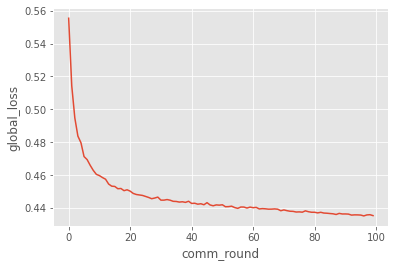

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import style
plt.style.use('ggplot')
plt.plot(global_model_loss)
plt.xlabel('comm_round')
plt.ylabel('global_loss')
# plt.rcParams.update({'font.size': 22})
plt.show()

global_model_loss_adam = pd.DataFrame(global_model_loss)
global_model_loss_adam.to_csv('global_model_loss_SGD.csv')

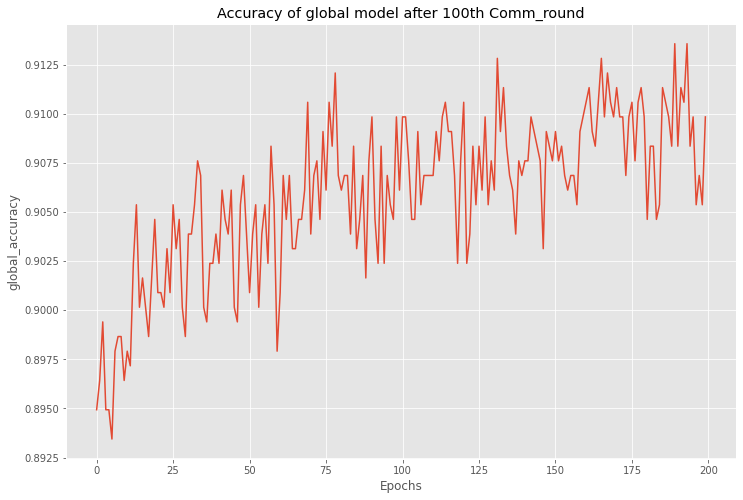

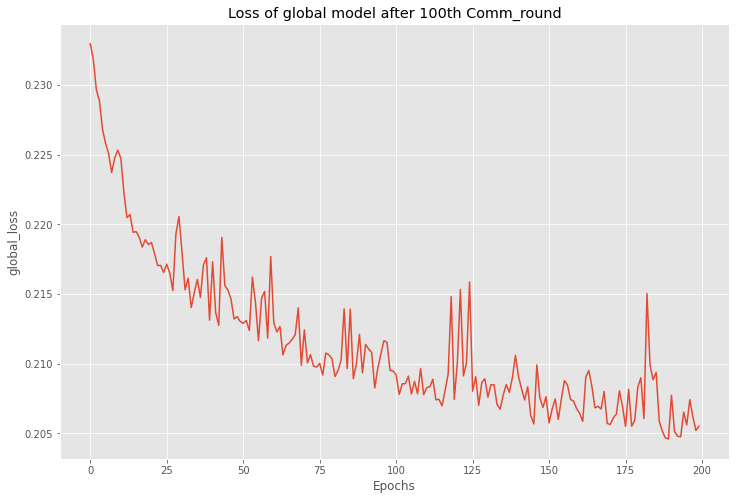

In [ ]:
acc_global_SGD = model_history.history['accuracy']
import matplotlib.pyplot as plt
from matplotlib import style
plt.style.use('ggplot')
plt.figure(figsize= (12,8))
plt.plot(acc_global_SGD)
plt.title('Accuracy of global model after 100th Comm_round')
plt.xlabel('Epochs')
plt.ylabel('global_accuracy')
# plt.rcParams.update({'font.size': 22})
plt.show()

loss_global_SGD = model_history.history['loss']
plt.style.use('ggplot')
plt.figure(figsize= (12,8))
plt.plot(loss_global_SGD)
plt.title('Loss of global model after 100th Comm_round')
plt.xlabel('Epochs')
plt.ylabel('global_loss')
# plt.rcParams.update({'font.size': 22})
plt.show()

In [ ]:
acc_global_SGD = pd.DataFrame(acc_global_SGD)
acc_global_SGD.to_csv('acc_global_SGD.csv')
loss_global_SGD = pd.DataFrame(loss_global_SGD)
loss_global_SGD.to_csv('loss_global_SGD.csv')

## **ADAM**

In [ ]:
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import Adam
lr = 0.01 
comms_round = 100
loss='sparse_categorical_crossentropy'
metrics = ['accuracy']
# lr_schedule = ExponentialDecay(
#     initial_learning_rate=0.01,
#     decay_steps=10000,
#     decay_rate=lr / comms_round) 
# optimizer = Adam(learning_rate = lr_schedule)   
optimizer = Adam(learning_rate = 0.01, decay = lr/comms_round)          

In [ ]:
def weight_scalling_factor(clients_trn_data, client_name):
    client_names = list(clients_trn_data.keys())
    bs = list(clients_trn_data[client_name])[0][0].shape[0]
    global_count = sum([tf.data.experimental.cardinality(clients_trn_data[client_name]).numpy() for client_name in client_names])*bs
    local_count = tf.data.experimental.cardinality(clients_trn_data[client_name]).numpy()*bs
    return local_count/global_count


def scale_model_weights(weight, scalar):
    '''function for scaling a models weights'''
    weight_final = []
    steps = len(weight)
    for i in range(steps):
        weight_final.append(scalar * weight[i])
    return weight_final



def sum_scaled_weights(scaled_weight_list):
    '''Return the sum of the listed scaled weights. The is equivalent to scaled avg of the weights'''
    avg_grad = list()
    for grad_list_tuple in zip(*scaled_weight_list):
        layer_mean = tf.math.reduce_sum(grad_list_tuple, axis=0)
        avg_grad.append(layer_mean)
        
    return avg_grad


def test_model(X_test, Y_test,  model, comm_round):
    cce = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    logits = model.predict(X_test)
    loss = cce(Y_test, logits)
    acc = accuracy_score(tf.argmax(logits, axis=1), tf.argmax(Y_test, axis=1))
    print('comm_round: {} | global_acc: {:.3%} | global_loss: {}'.format(comm_round, acc, loss))
    return acc, loss

In [ ]:
global_model_loss_adam = []
smlp_global = SimpleMLP()
global_model = smlp_global.build(15, 2)
for comm_round in range(comms_round):
    global_weights = global_model.get_weights()
    scaled_local_weight_list = list()
    client_names= list(clients_batched.keys())
    random.shuffle(client_names)
    for client in client_names:
        smlp_local = SimpleMLP()
        local_model = smlp_local.build(15, 2)
        local_model.compile(loss=loss, 
                      optimizer=optimizer, 
                      metrics=metrics)
        local_model.set_weights(global_weights)
        if comm_round is not 99:
            local_model.fit(clients_batched[client], epochs=200, verbose=0)
        else:
            model_history = local_model.fit(clients_batched[client], epochs=200, verbose=1)
        scaling_factor = weight_scalling_factor(clients_batched, client)
        scaled_weights = scale_model_weights(local_model.get_weights(), scaling_factor)
        scaled_local_weight_list.append(scaled_weights)
        K.clear_session()
    average_weights = sum_scaled_weights(scaled_local_weight_list)
    global_model.set_weights(average_weights)
    for(X_test, Y_test) in test_batched:
        global_acc, global_loss = test_model(X_test, Y_test, global_model, comm_round)
        global_model_loss_adam.append(global_loss)

comm_round: 0 | global_acc: 2.145% | global_loss: 0.69356369972229
comm_round: 1 | global_acc: 31.367% | global_loss: 0.5218782424926758
comm_round: 2 | global_acc: 36.327% | global_loss: 0.5027860999107361
comm_round: 3 | global_acc: 39.008% | global_loss: 0.4967038929462433
comm_round: 4 | global_acc: 41.287% | global_loss: 0.4901396632194519
comm_round: 5 | global_acc: 41.019% | global_loss: 0.48934927582740784
comm_round: 6 | global_acc: 41.555% | global_loss: 0.4867178201675415
comm_round: 7 | global_acc: 42.627% | global_loss: 0.4833967089653015
comm_round: 8 | global_acc: 43.968% | global_loss: 0.4816513657569885
comm_round: 9 | global_acc: 42.627% | global_loss: 0.48112308979034424
comm_round: 10 | global_acc: 43.834% | global_loss: 0.47870081663131714
comm_round: 11 | global_acc: 44.370% | global_loss: 0.4768397808074951
comm_round: 12 | global_acc: 43.432% | global_loss: 0.474833220243454
comm_round: 13 | global_acc: 44.102% | global_loss: 0.47554969787597656
comm_round: 14 |

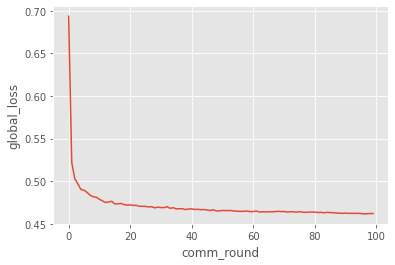

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import style


plt.style.use('ggplot')
plt.plot(global_model_loss_adam)
plt.xlabel('comm_round')
plt.ylabel('global_loss')
# plt.rcParams.update({'font.size': 22})
plt.show()

global_model_loss_adam = pd.DataFrame(global_model_loss_adam)
global_model_loss_adam.to_csv('global_model_loss_adam.csv')

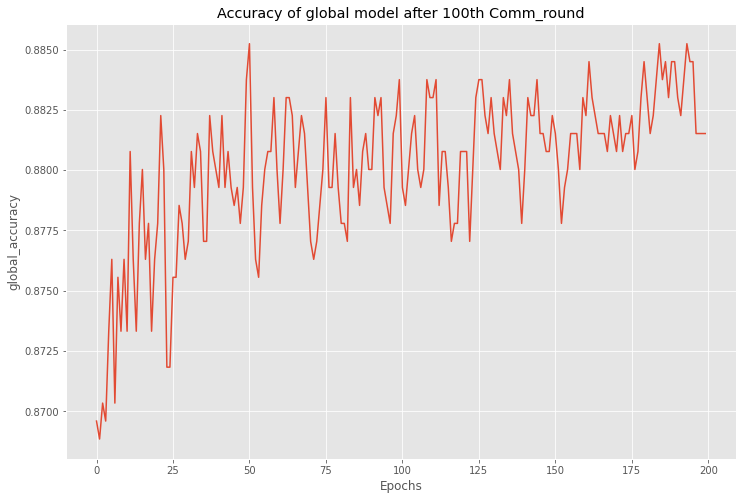

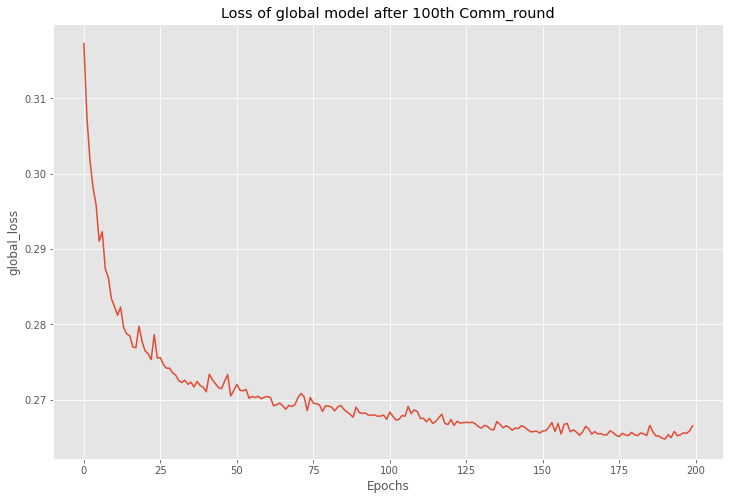

In [ ]:
acc_global_SGD = model_history.history['accuracy']
import matplotlib.pyplot as plt
from matplotlib import style
plt.style.use('ggplot')
plt.figure(figsize= (12,8))
plt.plot(acc_global_SGD)
plt.title('Accuracy of global model after 100th Comm_round')
plt.xlabel('Epochs')
plt.ylabel('global_accuracy')
# plt.rcParams.update({'font.size': 22})
plt.show()

loss_global_SGD = model_history.history['loss']
plt.style.use('ggplot')
plt.figure(figsize= (12,8))
plt.plot(loss_global_SGD)
plt.title('Loss of global model after 100th Comm_round')
plt.xlabel('Epochs')
plt.ylabel('global_loss')
# plt.rcParams.update({'font.size': 22})
plt.show()

In [ ]:
acc_global_SGD = pd.DataFrame(acc_global_SGD)
acc_global_SGD.to_csv('acc_global_adam.csv')
loss_global_SGD = pd.DataFrame(loss_global_SGD)
loss_global_SGD.to_csv('loss_global_adam.csv')

## **RMSProp**

In [ ]:
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import RMSprop
lr = 0.01 
comms_round = 100
loss='sparse_categorical_crossentropy'
metrics = ['accuracy']
optimizer = RMSprop(learning_rate=lr, 
                decay=lr / comms_round, 
                momentum=0.9
               )    
# lr_schedule = ExponentialDecay(
#     initial_learning_rate=0.01,
#     decay_steps=10000,
#     decay_rate=lr / comms_round) 
# optimizer = RMSprop(learning_rate = lr_schedule)             

In [ ]:
def weight_scalling_factor(clients_trn_data, client_name):
    client_names = list(clients_trn_data.keys())
    bs = list(clients_trn_data[client_name])[0][0].shape[0]
    global_count = sum([tf.data.experimental.cardinality(clients_trn_data[client_name]).numpy() for client_name in client_names])*bs
    local_count = tf.data.experimental.cardinality(clients_trn_data[client_name]).numpy()*bs
    return local_count/global_count


def scale_model_weights(weight, scalar):
    '''function for scaling a models weights'''
    weight_final = []
    steps = len(weight)
    for i in range(steps):
        weight_final.append(scalar * weight[i])
    return weight_final



def sum_scaled_weights(scaled_weight_list):
    '''Return the sum of the listed scaled weights. The is equivalent to scaled avg of the weights'''
    avg_grad = list()
    for grad_list_tuple in zip(*scaled_weight_list):
        layer_mean = tf.math.reduce_sum(grad_list_tuple, axis=0)
        avg_grad.append(layer_mean)
        
    return avg_grad


def test_model(X_test, Y_test,  model, comm_round):
    cce = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    logits = model.predict(X_test)
    loss = cce(Y_test, logits)
    acc = accuracy_score(tf.argmax(logits, axis=1), tf.argmax(Y_test, axis=1))
    print('comm_round: {} | global_acc: {:.3%} | global_loss: {}'.format(comm_round, acc, loss))
    return acc, loss

In [ ]:
global_model_loss_rmsprop = []
smlp_global = SimpleMLP()
global_model = smlp_global.build(15, 2)
for comm_round in range(comms_round):
    global_weights = global_model.get_weights()
    scaled_local_weight_list = list()
    client_names= list(clients_batched.keys())
    random.shuffle(client_names)
    for client in client_names:
        smlp_local = SimpleMLP()
        local_model = smlp_local.build(15, 2)
        local_model.compile(loss=loss, 
                      optimizer=optimizer, 
                      metrics=metrics)
        local_model.set_weights(global_weights)
        if comm_round is not 99:
            local_model.fit(clients_batched[client], epochs=200, verbose=0)
        else:
            model_history = local_model.fit(clients_batched[client], epochs=200, verbose=1)
        scaling_factor = weight_scalling_factor(clients_batched, client)
        scaled_weights = scale_model_weights(local_model.get_weights(), scaling_factor)
        scaled_local_weight_list.append(scaled_weights)
        K.clear_session()
    average_weights = sum_scaled_weights(scaled_local_weight_list)
    global_model.set_weights(average_weights)
    for(X_test, Y_test) in test_batched:
        global_acc, global_loss = test_model(X_test, Y_test, global_model, comm_round)
        global_model_loss_rmsprop.append(global_loss)

comm_round: 0 | global_acc: 0.000% | global_loss: 0.7508902549743652
comm_round: 1 | global_acc: 16.488% | global_loss: 0.614916205406189
comm_round: 2 | global_acc: 30.027% | global_loss: 0.5350468158721924
comm_round: 3 | global_acc: 35.791% | global_loss: 0.4918992519378662
comm_round: 4 | global_acc: 36.997% | global_loss: 0.48079320788383484
comm_round: 5 | global_acc: 42.761% | global_loss: 0.4772741496562958
comm_round: 6 | global_acc: 43.566% | global_loss: 0.4749453067779541
comm_round: 7 | global_acc: 45.442% | global_loss: 0.475336492061615
comm_round: 8 | global_acc: 42.627% | global_loss: 0.46871694922447205
comm_round: 9 | global_acc: 43.298% | global_loss: 0.47101891040802
comm_round: 10 | global_acc: 43.968% | global_loss: 0.46933820843696594
comm_round: 11 | global_acc: 43.029% | global_loss: 0.46665647625923157
comm_round: 12 | global_acc: 43.968% | global_loss: 0.4690682291984558
comm_round: 13 | global_acc: 43.834% | global_loss: 0.4668083190917969
comm_round: 14 | 

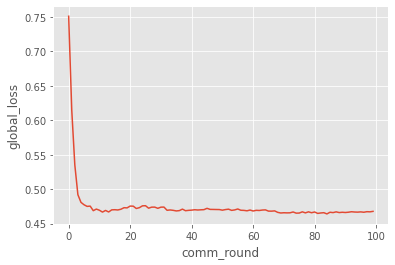

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import style


plt.style.use('ggplot')
plt.plot(global_model_loss_rmsprop)
plt.xlabel('comm_round')
plt.ylabel('global_loss')
# plt.rcParams.update({'font.size': 22})
plt.show()

global_model_loss_rmsprop = pd.DataFrame(global_model_loss_rmsprop)
global_model_loss_rmsprop.to_csv('global_model_loss_rmsprop.csv')

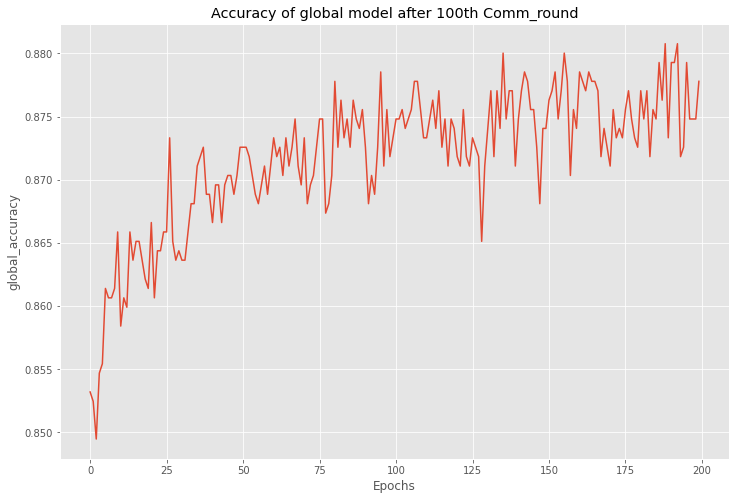

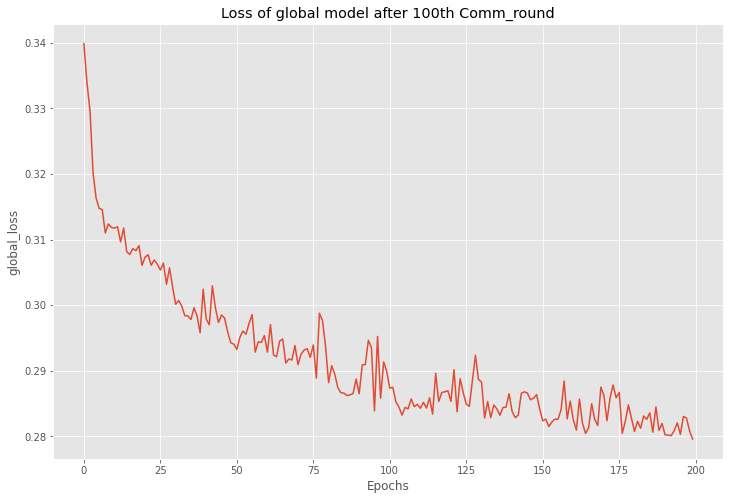

In [ ]:
acc_global_SGD = model_history.history['accuracy']
import matplotlib.pyplot as plt
from matplotlib import style
plt.style.use('ggplot')
plt.figure(figsize= (12,8))
plt.plot(acc_global_SGD)
plt.title('Accuracy of global model after 100th Comm_round')
plt.xlabel('Epochs')
plt.ylabel('global_accuracy')
# plt.rcParams.update({'font.size': 22})
plt.show()

loss_global_SGD = model_history.history['loss']
plt.style.use('ggplot')
plt.figure(figsize= (12,8))
plt.plot(loss_global_SGD)
plt.title('Loss of global model after 100th Comm_round')
plt.xlabel('Epochs')
plt.ylabel('global_loss')
# plt.rcParams.update({'font.size': 22})
plt.show()

In [ ]:
acc_global_SGD = pd.DataFrame(acc_global_SGD)
acc_global_SGD.to_csv('acc_global_rmsprop.csv')
loss_global_SGD = pd.DataFrame(loss_global_SGD)
loss_global_SGD.to_csv('loss_global_rmsprop.csv')

## **ADAMAX**

In [ ]:
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import Adamax
lr = 0.01 
comms_round = 100
loss='sparse_categorical_crossentropy'
metrics = ['accuracy']
optimizer = Adamax(learning_rate=lr, 
                decay=lr / comms_round
               )    
# lr_schedule = ExponentialDecay(
#     initial_learning_rate=0.01,
#     decay_steps=10000,
#     decay_rate=lr / comms_round) 
# optimizer = RMSprop(learning_rate = lr_schedule)             

In [ ]:
def weight_scalling_factor(clients_trn_data, client_name):
    client_names = list(clients_trn_data.keys())
    bs = list(clients_trn_data[client_name])[0][0].shape[0]
    global_count = sum([tf.data.experimental.cardinality(clients_trn_data[client_name]).numpy() for client_name in client_names])*bs
    local_count = tf.data.experimental.cardinality(clients_trn_data[client_name]).numpy()*bs
    return local_count/global_count


def scale_model_weights(weight, scalar):
    '''function for scaling a models weights'''
    weight_final = []
    steps = len(weight)
    for i in range(steps):
        weight_final.append(scalar * weight[i])
    return weight_final



def sum_scaled_weights(scaled_weight_list):
    '''Return the sum of the listed scaled weights. The is equivalent to scaled avg of the weights'''
    avg_grad = list()
    for grad_list_tuple in zip(*scaled_weight_list):
        layer_mean = tf.math.reduce_sum(grad_list_tuple, axis=0)
        avg_grad.append(layer_mean)
        
    return avg_grad


def test_model(X_test, Y_test,  model, comm_round):
    cce = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    logits = model.predict(X_test)
    loss = cce(Y_test, logits)
    acc = accuracy_score(tf.argmax(logits, axis=1), tf.argmax(Y_test, axis=1))
    print('comm_round: {} | global_acc: {:.3%} | global_loss: {}'.format(comm_round, acc, loss))
    return acc, loss

In [ ]:
global_model_loss_adamax = []
smlp_global = SimpleMLP()
global_model = smlp_global.build(15, 2)
for comm_round in range(comms_round):
    global_weights = global_model.get_weights()
    scaled_local_weight_list = list()
    client_names= list(clients_batched.keys())
    random.shuffle(client_names)
    for client in client_names:
        smlp_local = SimpleMLP()
        local_model = smlp_local.build(15, 2)
        local_model.compile(loss=loss, 
                      optimizer=optimizer, 
                      metrics=metrics)
        local_model.set_weights(global_weights)
        if comm_round is not 99:
            local_model.fit(clients_batched[client], epochs=200, verbose=0)
        else:
            model_history = local_model.fit(clients_batched[client], epochs=200, verbose=1)
        scaling_factor = weight_scalling_factor(clients_batched, client)
        scaled_weights = scale_model_weights(local_model.get_weights(), scaling_factor)
        scaled_local_weight_list.append(scaled_weights)
        K.clear_session()
    average_weights = sum_scaled_weights(scaled_local_weight_list)
    global_model.set_weights(average_weights)
    for(X_test, Y_test) in test_batched:
        global_acc, global_loss = test_model(X_test, Y_test, global_model, comm_round)
        global_model_loss_adamax.append(global_loss)

comm_round: 0 | global_acc: 45.174% | global_loss: 0.5124760866165161
comm_round: 1 | global_acc: 37.131% | global_loss: 0.45725905895233154
comm_round: 2 | global_acc: 40.214% | global_loss: 0.4462724030017853
comm_round: 3 | global_acc: 43.164% | global_loss: 0.4307018220424652
comm_round: 4 | global_acc: 46.113% | global_loss: 0.4234670400619507
comm_round: 5 | global_acc: 47.453% | global_loss: 0.4219358265399933
comm_round: 6 | global_acc: 46.917% | global_loss: 0.4210185706615448
comm_round: 7 | global_acc: 44.638% | global_loss: 0.4183608293533325
comm_round: 8 | global_acc: 48.660% | global_loss: 0.41548144817352295
comm_round: 9 | global_acc: 46.113% | global_loss: 0.415780633687973
comm_round: 10 | global_acc: 45.040% | global_loss: 0.41619452834129333
comm_round: 11 | global_acc: 45.845% | global_loss: 0.41445857286453247
comm_round: 12 | global_acc: 48.928% | global_loss: 0.41331273317337036
comm_round: 13 | global_acc: 46.113% | global_loss: 0.41360223293304443
comm_round:

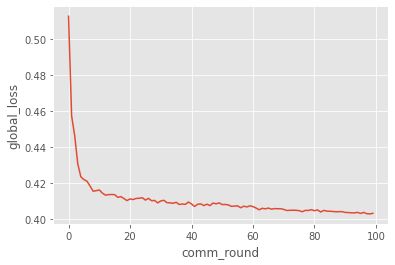

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import style


plt.style.use('ggplot')
plt.plot(global_model_loss_adamax)
plt.xlabel('comm_round')
plt.ylabel('global_loss')
# plt.rcParams.update({'font.size': 22})
plt.show()

global_model_loss_adamax = pd.DataFrame(global_model_loss_adamax)
global_model_loss_adamax.to_csv('global_model_loss_adamax.csv')

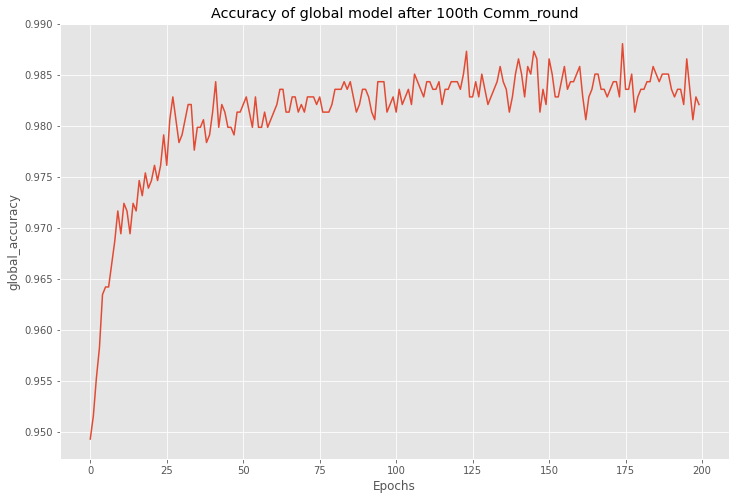

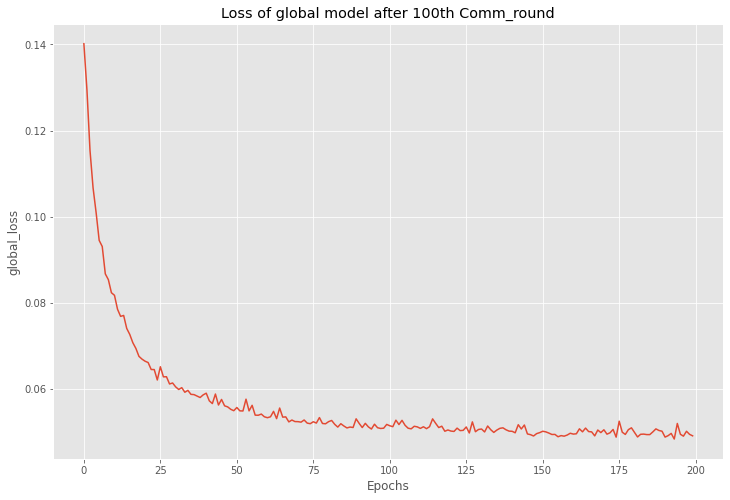

In [ ]:
acc_global_SGD = model_history.history['accuracy']
import matplotlib.pyplot as plt
from matplotlib import style
plt.style.use('ggplot')
plt.figure(figsize= (12,8))
plt.plot(acc_global_SGD)
plt.title('Accuracy of global model after 100th Comm_round')
plt.xlabel('Epochs')
plt.ylabel('global_accuracy')
# plt.rcParams.update({'font.size': 22})
plt.show()

loss_global_SGD = model_history.history['loss']
plt.style.use('ggplot')
plt.figure(figsize= (12,8))
plt.plot(loss_global_SGD)
plt.title('Loss of global model after 100th Comm_round')
plt.xlabel('Epochs')
plt.ylabel('global_loss')
# plt.rcParams.update({'font.size': 22})
plt.show()

In [ ]:
acc_global_SGD = pd.DataFrame(acc_global_SGD)
acc_global_SGD.to_csv('acc_global_adamax.csv')
loss_global_SGD = pd.DataFrame(loss_global_SGD)
loss_global_SGD.to_csv('loss_global_adamax.csv')

## **FTRL --> not working**

In [ ]:
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import Ftrl
lr = 0.01 
comms_round = 100
loss='sparse_categorical_crossentropy'
metrics = ['accuracy']
optimizer = Ftrl(learning_rate=lr, 
                decay=lr / comms_round
               )    
# lr_schedule = ExponentialDecay(
#     initial_learning_rate=0.01,
#     decay_steps=10000,
#     decay_rate=lr / comms_round) 
# optimizer = RMSprop(learning_rate = lr_schedule)             

In [ ]:
def weight_scalling_factor(clients_trn_data, client_name):
    client_names = list(clients_trn_data.keys())
    bs = list(clients_trn_data[client_name])[0][0].shape[0]
    global_count = sum([tf.data.experimental.cardinality(clients_trn_data[client_name]).numpy() for client_name in client_names])*bs
    local_count = tf.data.experimental.cardinality(clients_trn_data[client_name]).numpy()*bs
    return local_count/global_count


def scale_model_weights(weight, scalar):
    '''function for scaling a models weights'''
    weight_final = []
    steps = len(weight)
    for i in range(steps):
        weight_final.append(scalar * weight[i])
    return weight_final



def sum_scaled_weights(scaled_weight_list):
    '''Return the sum of the listed scaled weights. The is equivalent to scaled avg of the weights'''
    avg_grad = list()
    for grad_list_tuple in zip(*scaled_weight_list):
        layer_mean = tf.math.reduce_sum(grad_list_tuple, axis=0)
        avg_grad.append(layer_mean)
        
    return avg_grad


def test_model(X_test, Y_test,  model, comm_round):
    cce = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    logits = model.predict(X_test)
    loss = cce(Y_test, logits)
    acc = accuracy_score(tf.argmax(logits, axis=1), tf.argmax(Y_test, axis=1))
    print('comm_round: {} | global_acc: {:.3%} | global_loss: {}'.format(comm_round, acc, loss))
    return acc, loss

In [ ]:
global_model_loss_ftrl = []
smlp_global = SimpleMLP()
global_model = smlp_global.build(15, 2)
for comm_round in range(comms_round):
    global_weights = global_model.get_weights()
    scaled_local_weight_list = list()
    client_names= list(clients_batched.keys())
    random.shuffle(client_names)
    for client in client_names:
        smlp_local = SimpleMLP()
        local_model = smlp_local.build(15, 2)
        local_model.compile(loss=loss, 
                      optimizer=optimizer, 
                      metrics=metrics)
        local_model.set_weights(global_weights)
        if comm_round is not 99:
            local_model.fit(clients_batched[client], epochs=200, verbose=0)
        else:
            model_history = local_model.fit(clients_batched[client], epochs=200, verbose=1)
        scaling_factor = weight_scalling_factor(clients_batched, client)
        scaled_weights = scale_model_weights(local_model.get_weights(), scaling_factor)
        scaled_local_weight_list.append(scaled_weights)
        K.clear_session()
    average_weights = sum_scaled_weights(scaled_local_weight_list)
    global_model.set_weights(average_weights)
    for(X_test, Y_test) in test_batched:
        global_acc, global_loss = test_model(X_test, Y_test, global_model, comm_round)
        global_model_loss_ftrl.append(global_loss)

comm_round: 0 | global_acc: 100.000% | global_loss: 0.6931473612785339
comm_round: 1 | global_acc: 100.000% | global_loss: 0.6931473612785339
comm_round: 2 | global_acc: 0.000% | global_loss: 0.6931474804878235
comm_round: 3 | global_acc: 100.000% | global_loss: 0.6931473612785339
comm_round: 4 | global_acc: 100.000% | global_loss: 0.6931468844413757
comm_round: 5 | global_acc: 100.000% | global_loss: 0.6931470632553101
comm_round: 6 | global_acc: 0.000% | global_loss: 0.6931470036506653
comm_round: 7 | global_acc: 0.000% | global_loss: 0.6931473612785339
comm_round: 8 | global_acc: 100.000% | global_loss: 0.693146824836731
comm_round: 9 | global_acc: 0.000% | global_loss: 0.6931474804878235
comm_round: 10 | global_acc: 100.000% | global_loss: 0.6931473612785339
comm_round: 11 | global_acc: 100.000% | global_loss: 0.6931475400924683
comm_round: 12 | global_acc: 100.000% | global_loss: 0.6931473612785339
comm_round: 13 | global_acc: 100.000% | global_loss: 0.6931473612785339
comm_round:

KeyboardInterrupt: ignored

## **NADAM -> not Working**

In [ ]:
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import Nadam
lr = 0.01 
comms_round = 100
loss='sparse_categorical_crossentropy'
metrics = ['accuracy']
optimizer = Nadam(learning_rate=lr, 
                decay=lr / comms_round
               )    
# lr_schedule = ExponentialDecay(
#     initial_learning_rate=0.01,
#     decay_steps=10000,
#     decay_rate=lr / comms_round) 
# optimizer = RMSprop(learning_rate = lr_schedule)             

In [ ]:
def weight_scalling_factor(clients_trn_data, client_name):
    client_names = list(clients_trn_data.keys())
    bs = list(clients_trn_data[client_name])[0][0].shape[0]
    global_count = sum([tf.data.experimental.cardinality(clients_trn_data[client_name]).numpy() for client_name in client_names])*bs
    local_count = tf.data.experimental.cardinality(clients_trn_data[client_name]).numpy()*bs
    return local_count/global_count


def scale_model_weights(weight, scalar):
    '''function for scaling a models weights'''
    weight_final = []
    steps = len(weight)
    for i in range(steps):
        weight_final.append(scalar * weight[i])
    return weight_final



def sum_scaled_weights(scaled_weight_list):
    '''Return the sum of the listed scaled weights. The is equivalent to scaled avg of the weights'''
    avg_grad = list()
    for grad_list_tuple in zip(*scaled_weight_list):
        layer_mean = tf.math.reduce_sum(grad_list_tuple, axis=0)
        avg_grad.append(layer_mean)
        
    return avg_grad


def test_model(X_test, Y_test,  model, comm_round):
    cce = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    logits = model.predict(X_test)
    loss = cce(Y_test, logits)
    acc = accuracy_score(tf.argmax(logits, axis=1), tf.argmax(Y_test, axis=1))
    print('comm_round: {} | global_acc: {:.3%} | global_loss: {}'.format(comm_round, acc, loss))
    return acc, loss

In [ ]:
global_model_loss_adamax = []
smlp_global = SimpleMLP()
global_model = smlp_global.build(15, 2)
for comm_round in range(comms_round):
    global_weights = global_model.get_weights()
    scaled_local_weight_list = list()
    client_names= list(clients_batched.keys())
    random.shuffle(client_names)
    for client in client_names:
        smlp_local = SimpleMLP()
        local_model = smlp_local.build(15, 2)
        local_model.compile(loss=loss, 
                      optimizer=optimizer, 
                      metrics=metrics)
        local_model.set_weights(global_weights)
        if comm_round is not 99:
            local_model.fit(clients_batched[client], epochs=200, verbose=0)
        else:
            model_history = local_model.fit(clients_batched[client], epochs=200, verbose=1)
        scaling_factor = weight_scalling_factor(clients_batched, client)
        scaled_weights = scale_model_weights(local_model.get_weights(), scaling_factor)
        scaled_local_weight_list.append(scaled_weights)
        K.clear_session()
    average_weights = sum_scaled_weights(scaled_local_weight_list)
    global_model.set_weights(average_weights)
    for(X_test, Y_test) in test_batched:
        global_acc, global_loss = test_model(X_test, Y_test, global_model, comm_round)
        global_model_loss_adamax.append(global_loss)

comm_round: 0 | global_acc: 0.000% | global_loss: 0.718776524066925
comm_round: 1 | global_acc: 0.000% | global_loss: 0.6931473016738892
comm_round: 2 | global_acc: 0.000% | global_loss: 0.6931520700454712
comm_round: 3 | global_acc: 100.000% | global_loss: 0.6931527256965637
comm_round: 4 | global_acc: 100.000% | global_loss: 0.6931471228599548
comm_round: 5 | global_acc: 0.000% | global_loss: 0.6931518316268921
comm_round: 6 | global_acc: 0.000% | global_loss: 0.6931489706039429
comm_round: 7 | global_acc: 0.000% | global_loss: 0.6931487917900085
comm_round: 8 | global_acc: 100.000% | global_loss: 0.693148136138916
comm_round: 9 | global_acc: 0.000% | global_loss: 0.6931490898132324
comm_round: 10 | global_acc: 0.000% | global_loss: 0.6931514143943787
comm_round: 11 | global_acc: 100.000% | global_loss: 0.6931473016738892
comm_round: 12 | global_acc: 0.000% | global_loss: 0.6931505799293518
comm_round: 13 | global_acc: 0.000% | global_loss: 0.6931509971618652
comm_round: 14 | global_

## **Adadelta**

In [ ]:
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import Adadelta
lr = 0.01 
comms_round = 100
loss='sparse_categorical_crossentropy'
metrics = ['accuracy']
optimizer = Adadelta(learning_rate=lr, 
                decay=lr / comms_round
               )    
# lr_schedule = ExponentialDecay(
#     initial_learning_rate=0.01,
#     decay_steps=10000,
#     decay_rate=lr / comms_round) 
# optimizer = RMSprop(learning_rate = lr_schedule)             

In [ ]:
def weight_scalling_factor(clients_trn_data, client_name):
    client_names = list(clients_trn_data.keys())
    bs = list(clients_trn_data[client_name])[0][0].shape[0]
    global_count = sum([tf.data.experimental.cardinality(clients_trn_data[client_name]).numpy() for client_name in client_names])*bs
    local_count = tf.data.experimental.cardinality(clients_trn_data[client_name]).numpy()*bs
    return local_count/global_count


def scale_model_weights(weight, scalar):
    '''function for scaling a models weights'''
    weight_final = []
    steps = len(weight)
    for i in range(steps):
        weight_final.append(scalar * weight[i])
    return weight_final



def sum_scaled_weights(scaled_weight_list):
    '''Return the sum of the listed scaled weights. The is equivalent to scaled avg of the weights'''
    avg_grad = list()
    for grad_list_tuple in zip(*scaled_weight_list):
        layer_mean = tf.math.reduce_sum(grad_list_tuple, axis=0)
        avg_grad.append(layer_mean)
        
    return avg_grad


def test_model(X_test, Y_test,  model, comm_round):
    cce = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    logits = model.predict(X_test)
    loss = cce(Y_test, logits)
    acc = accuracy_score(tf.argmax(logits, axis=1), tf.argmax(Y_test, axis=1))
    print('comm_round: {} | global_acc: {:.3%} | global_loss: {}'.format(comm_round, acc, loss))
    return acc, loss

In [ ]:
global_model_loss_adamax = []
smlp_global = SimpleMLP()
global_model = smlp_global.build(15, 2)
for comm_round in range(comms_round):
    global_weights = global_model.get_weights()
    scaled_local_weight_list = list()
    client_names= list(clients_batched.keys())
    random.shuffle(client_names)
    for client in client_names:
        smlp_local = SimpleMLP()
        local_model = smlp_local.build(15, 2)
        local_model.compile(loss=loss, 
                      optimizer=optimizer, 
                      metrics=metrics)
        local_model.set_weights(global_weights)
        if comm_round is not 99:
            local_model.fit(clients_batched[client], epochs=200, verbose=0)
        else:
            model_history = local_model.fit(clients_batched[client], epochs=200, verbose=1)
        scaling_factor = weight_scalling_factor(clients_batched, client)
        scaled_weights = scale_model_weights(local_model.get_weights(), scaling_factor)
        scaled_local_weight_list.append(scaled_weights)
        K.clear_session()
    average_weights = sum_scaled_weights(scaled_local_weight_list)
    global_model.set_weights(average_weights)
    for(X_test, Y_test) in test_batched:
        global_acc, global_loss = test_model(X_test, Y_test, global_model, comm_round)
        global_model_loss_adamax.append(global_loss)

comm_round: 0 | global_acc: 56.434% | global_loss: 0.6650757193565369
comm_round: 1 | global_acc: 54.960% | global_loss: 0.6521918773651123
comm_round: 2 | global_acc: 47.855% | global_loss: 0.6444801688194275
comm_round: 3 | global_acc: 44.504% | global_loss: 0.6390770077705383
comm_round: 4 | global_acc: 43.968% | global_loss: 0.6349329352378845
comm_round: 5 | global_acc: 43.298% | global_loss: 0.6316111087799072
comm_round: 6 | global_acc: 43.298% | global_loss: 0.628956139087677
comm_round: 7 | global_acc: 43.298% | global_loss: 0.6267727017402649
comm_round: 8 | global_acc: 43.566% | global_loss: 0.6250029802322388
comm_round: 9 | global_acc: 43.298% | global_loss: 0.6234257817268372
comm_round: 10 | global_acc: 43.029% | global_loss: 0.6220036149024963
comm_round: 11 | global_acc: 43.029% | global_loss: 0.6207472681999207
comm_round: 12 | global_acc: 42.895% | global_loss: 0.6196162104606628
comm_round: 13 | global_acc: 42.627% | global_loss: 0.6185624003410339
comm_round: 14 | 

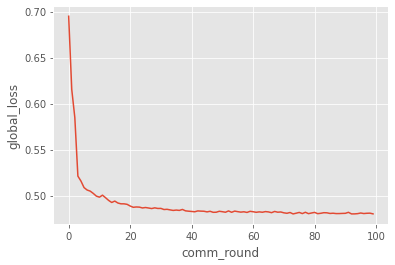

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import style


plt.style.use('ggplot')
plt.plot(global_model_loss_adam)
plt.xlabel('comm_round')
plt.ylabel('global_loss')
# plt.rcParams.update({'font.size': 22})
plt.show()

global_model_loss_adamax = pd.DataFrame(global_model_loss_adamax)
global_model_loss_adamax.to_csv('global_model_loss_adadelta.csv')

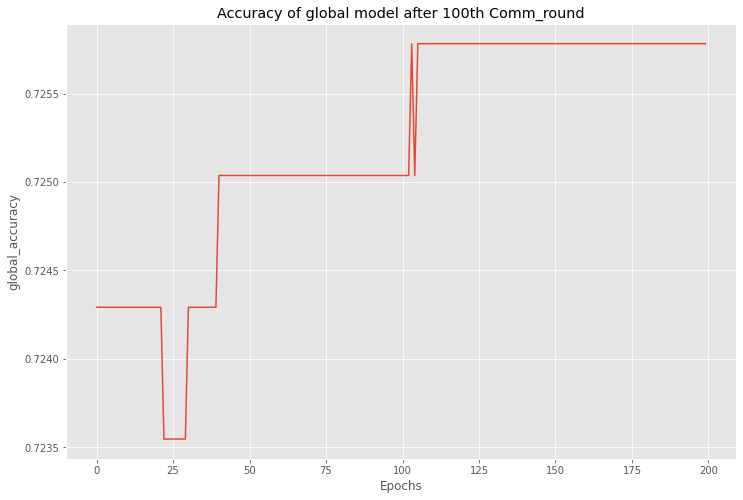

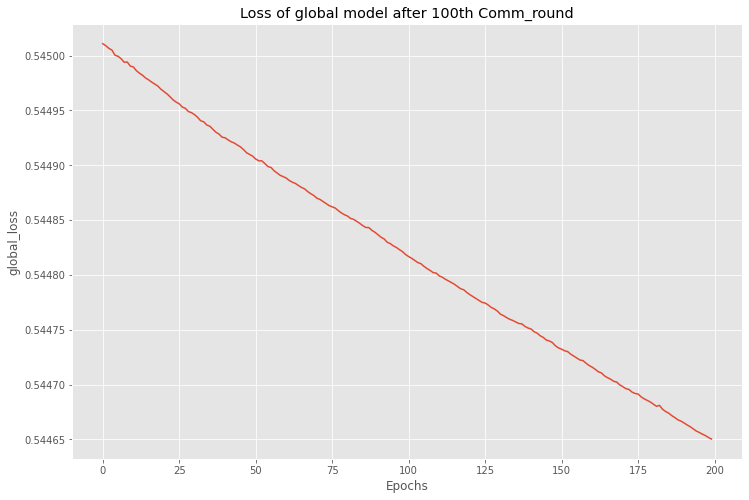

In [ ]:
acc_global_SGD = model_history.history['accuracy']
import matplotlib.pyplot as plt
from matplotlib import style
plt.style.use('ggplot')
plt.figure(figsize= (12,8))
plt.plot(acc_global_SGD)
plt.title('Accuracy of global model after 100th Comm_round')
plt.xlabel('Epochs')
plt.ylabel('global_accuracy')
# plt.rcParams.update({'font.size': 22})
plt.show()

loss_global_SGD = model_history.history['loss']
plt.style.use('ggplot')
plt.figure(figsize= (12,8))
plt.plot(loss_global_SGD)
plt.title('Loss of global model after 100th Comm_round')
plt.xlabel('Epochs')
plt.ylabel('global_loss')
# plt.rcParams.update({'font.size': 22})
plt.show()

In [ ]:
acc_global_SGD = pd.DataFrame(acc_global_SGD)
acc_global_SGD.to_csv('acc_global_adadelta.csv')
loss_global_SGD = pd.DataFrame(loss_global_SGD)
loss_global_SGD.to_csv('loss_global_adadelta.csv')

## **Adagrad**

In [ ]:
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import Adagrad
lr = 0.01 
comms_round = 100
loss='sparse_categorical_crossentropy'
metrics = ['accuracy']
optimizer = Adagrad(learning_rate=lr, 
                decay=lr / comms_round
               )    
# lr_schedule = ExponentialDecay(
#     initial_learning_rate=0.01,
#     decay_steps=10000,
#     decay_rate=lr / comms_round) 
# optimizer = RMSprop(learning_rate = lr_schedule)             

In [ ]:
def weight_scalling_factor(clients_trn_data, client_name):
    client_names = list(clients_trn_data.keys())
    bs = list(clients_trn_data[client_name])[0][0].shape[0]
    global_count = sum([tf.data.experimental.cardinality(clients_trn_data[client_name]).numpy() for client_name in client_names])*bs
    local_count = tf.data.experimental.cardinality(clients_trn_data[client_name]).numpy()*bs
    return local_count/global_count


def scale_model_weights(weight, scalar):
    '''function for scaling a models weights'''
    weight_final = []
    steps = len(weight)
    for i in range(steps):
        weight_final.append(scalar * weight[i])
    return weight_final



def sum_scaled_weights(scaled_weight_list):
    '''Return the sum of the listed scaled weights. The is equivalent to scaled avg of the weights'''
    avg_grad = list()
    for grad_list_tuple in zip(*scaled_weight_list):
        layer_mean = tf.math.reduce_sum(grad_list_tuple, axis=0)
        avg_grad.append(layer_mean)
        
    return avg_grad


def test_model(X_test, Y_test,  model, comm_round):
    cce = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    logits = model.predict(X_test)
    loss = cce(Y_test, logits)
    acc = accuracy_score(tf.argmax(logits, axis=1), tf.argmax(Y_test, axis=1))
    print('comm_round: {} | global_acc: {:.3%} | global_loss: {}'.format(comm_round, acc, loss))
    return acc, loss

In [ ]:
global_model_loss_adagrad = []
smlp_global = SimpleMLP()
global_model = smlp_global.build(15, 2)
for comm_round in range(comms_round):
    global_weights = global_model.get_weights()
    scaled_local_weight_list = list()
    client_names= list(clients_batched.keys())
    random.shuffle(client_names)
    for client in client_names:
        smlp_local = SimpleMLP()
        local_model = smlp_local.build(15, 2)
        local_model.compile(loss=loss, 
                      optimizer=optimizer, 
                      metrics=metrics)
        local_model.set_weights(global_weights)
        if comm_round is not 99:
            local_model.fit(clients_batched[client], epochs=200, verbose=0)
        else:
            model_history = local_model.fit(clients_batched[client], epochs=200, verbose=1)
        scaling_factor = weight_scalling_factor(clients_batched, client)
        scaled_weights = scale_model_weights(local_model.get_weights(), scaling_factor)
        scaled_local_weight_list.append(scaled_weights)
        K.clear_session()
    average_weights = sum_scaled_weights(scaled_local_weight_list)
    global_model.set_weights(average_weights)
    for(X_test, Y_test) in test_batched:
        global_acc, global_loss = test_model(X_test, Y_test, global_model, comm_round)
        global_model_loss_adagrad.append(global_loss)

comm_round: 0 | global_acc: 41.823% | global_loss: 0.6085590124130249
comm_round: 1 | global_acc: 38.606% | global_loss: 0.5850789546966553
comm_round: 2 | global_acc: 39.410% | global_loss: 0.5719910860061646
comm_round: 3 | global_acc: 39.678% | global_loss: 0.5622075200080872
comm_round: 4 | global_acc: 40.483% | global_loss: 0.5551335215568542
comm_round: 5 | global_acc: 40.483% | global_loss: 0.5493026375770569
comm_round: 6 | global_acc: 40.349% | global_loss: 0.5443348288536072
comm_round: 7 | global_acc: 41.019% | global_loss: 0.5403992533683777
comm_round: 8 | global_acc: 41.019% | global_loss: 0.5369850993156433
comm_round: 9 | global_acc: 41.957% | global_loss: 0.5339866876602173
comm_round: 10 | global_acc: 41.957% | global_loss: 0.531307578086853
comm_round: 11 | global_acc: 42.895% | global_loss: 0.5291839838027954
comm_round: 12 | global_acc: 42.895% | global_loss: 0.5266480445861816
comm_round: 13 | global_acc: 42.627% | global_loss: 0.5246578454971313
comm_round: 14 | 

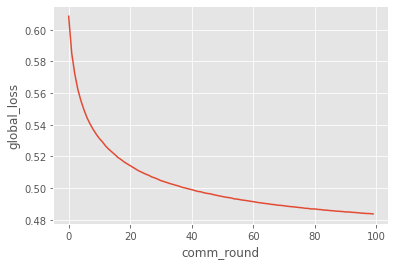

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import style


plt.style.use('ggplot')
plt.plot(global_model_loss_adagrad)
plt.xlabel('comm_round')
plt.ylabel('global_loss')
# plt.rcParams.update({'font.size': 22})
plt.show()

global_model_loss_adamax = pd.DataFrame(global_model_loss_adagrad)
global_model_loss_adamax.to_csv('global_model_loss_adagrad.csv')

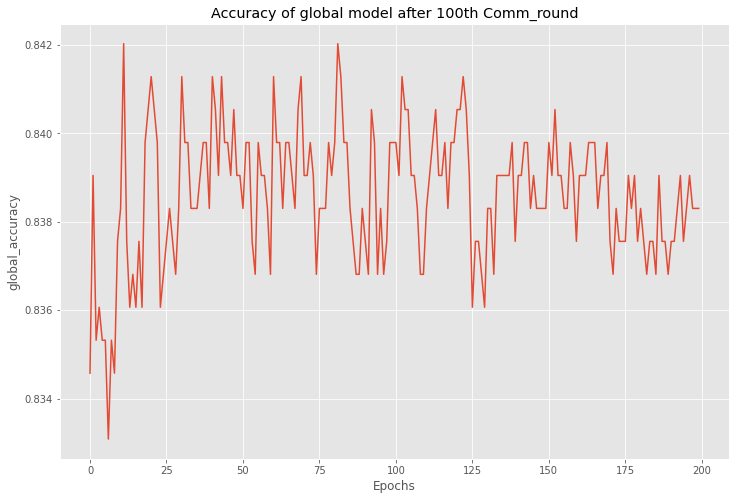

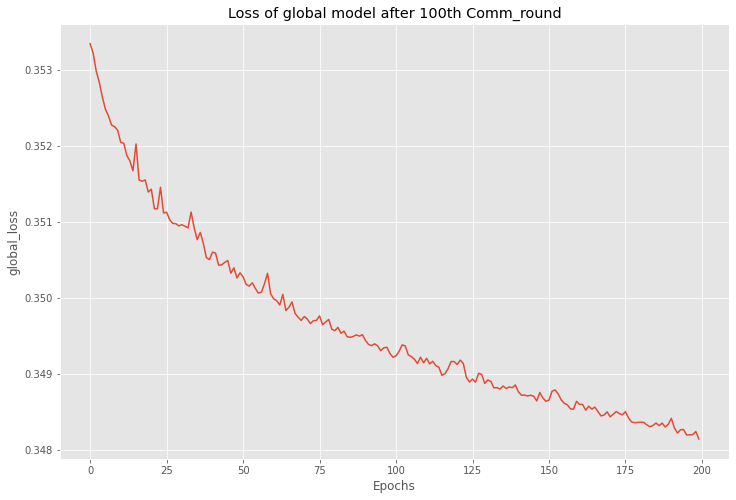

In [ ]:
acc_global_SGD = model_history.history['accuracy']
import matplotlib.pyplot as plt
from matplotlib import style
plt.style.use('ggplot')
plt.figure(figsize= (12,8))
plt.plot(acc_global_SGD)
plt.title('Accuracy of global model after 100th Comm_round')
plt.xlabel('Epochs')
plt.ylabel('global_accuracy')
# plt.rcParams.update({'font.size': 22})
plt.show()

loss_global_SGD = model_history.history['loss']
plt.style.use('ggplot')
plt.figure(figsize= (12,8))
plt.plot(loss_global_SGD)
plt.title('Loss of global model after 100th Comm_round')
plt.xlabel('Epochs')
plt.ylabel('global_loss')
# plt.rcParams.update({'font.size': 22})
plt.show()

In [ ]:
acc_global_SGD = pd.DataFrame(acc_global_SGD)
acc_global_SGD.to_csv('acc_global_adagrad.csv')
loss_global_SGD = pd.DataFrame(loss_global_SGD)
loss_global_SGD.to_csv('loss_global_adagrad.csv')

# **Centralized**

## SGD

In [ ]:
lr = 0.01 
comms_round = 100
loss='sparse_categorical_crossentropy'
metrics = ['accuracy']
optimizer = SGD(learning_rate=lr, 
                decay=lr / comms_round, 
                momentum=0.9
               )     

In [ ]:
def test_model(X_test, Y_test,  model, comm_round):
    cce = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    #logits = model.predict(X_test, batch_size=100)
    logits = model.predict(X_test)
    loss = cce(Y_test, logits)
    acc = accuracy_score(tf.argmax(logits, axis=1), tf.argmax(Y_test, axis=1))
    print('comm_round: {} | global_acc: {:.3%} | global_loss: {}'.format(comm_round, acc, loss))
    return acc, loss

In [ ]:
SGD_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(len(y_train)).batch(320)
smlp_SGD = SimpleMLP()
SGD_model = smlp_SGD.build(15, 2) 
SGD_model.compile(loss=loss, 
              optimizer=optimizer, 
              metrics=metrics)
history = SGD_model.fit(SGD_dataset, epochs=200, verbose=1)
for(X_test, Y_test) in test_batched:
        SGD_acc, SGD_loss = test_model(X_test, Y_test, SGD_model, 1)
##########################
# for comm_round in range(comms_round):
#   for(X_test, Y_test) in test_batched:
#     SGD_acc, SGD_loss = test_model(X_test, Y_test, SGD_model, comm_round)
##########################

Epoch 1/200
21/21 [==============================] - 2s 3ms/step - loss: 0.6826 - accuracy: 0.5767
Epoch 2/200
21/21 [==============================] - 0s 3ms/step - loss: 0.6594 - accuracy: 0.6266
Epoch 3/200
21/21 [==============================] - 0s 3ms/step - loss: 0.6427 - accuracy: 0.6268
Epoch 4/200
21/21 [==============================] - 0s 3ms/step - loss: 0.6307 - accuracy: 0.6287
Epoch 5/200
21/21 [==============================] - 0s 3ms/step - loss: 0.6209 - accuracy: 0.6410
Epoch 6/200
21/21 [==============================] - 0s 3ms/step - loss: 0.6116 - accuracy: 0.6637
Epoch 7/200
21/21 [==============================] - 0s 4ms/step - loss: 0.6036 - accuracy: 0.6725
Epoch 8/200
21/21 [==============================] - 0s 4ms/step - loss: 0.5956 - accuracy: 0.6810
Epoch 9/200
21/21 [==============================] - 0s 3ms/step - loss: 0.5887 - accuracy: 0.6911
Epoch 10/200
21/21 [==============================] - 0s 3ms/step - loss: 0.5823 - accuracy: 0.6997
Epoch 11/

dict_keys(['loss', 'accuracy'])


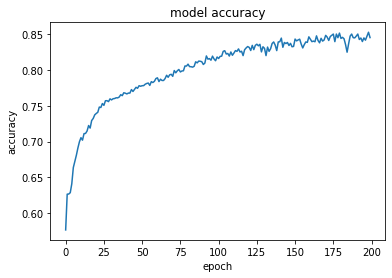

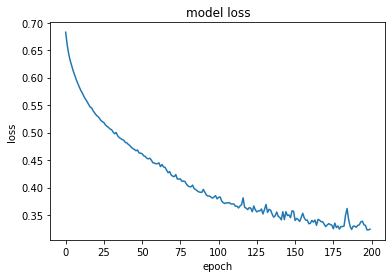

In [ ]:
SGD_acc_list = []
SGD_loss_list = []
# list all data in history
print(history.history.keys())
# summarize history for accuracy
SGD_acc_list = history.history['accuracy'] 
SGD_loss_list = history.history['loss'] 
plt.plot(history.history['accuracy'])
# plt.plot(history.history['])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
SGD_acc_list = pd.DataFrame(SGD_acc_list)
SGD_acc_list.to_csv('cen_SGD_acc_list.csv')
SGD_loss_list = pd.DataFrame(SGD_loss_list)
SGD_loss_list.to_csv('cen_SGD_loss_list.csv')
# SGD_acc_list = history.history['accuracy'] 
# SGD_loss_list

## **Adam**

In [ ]:
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import Adam
lr = 0.01 
comms_round = 100
loss='sparse_categorical_crossentropy'
metrics = ['accuracy']
optimizer = Adam(learning_rate = 0.01, decay = lr/comms_round)  

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
# lr = 0.01 
# comms_round = 100
# loss='sparse_categorical_crossentropy'
# metrics = ['accuracy']
# lr_schedule = ExponentialDecay(
#     initial_learning_rate=0.01,
#     decay_steps=10000,
#     decay_rate=lr / comms_round)
# optimizer = Adam(learning_rate=lr, 
#                 decay=lr / comms_round, 
#                 momentum=0.9
#                )  
# optimizer = Adam(learning_rate = lr_schedule)


SGD_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(len(y_train)).batch(320)
smlp_SGD = SimpleMLP()
SGD_model = smlp_SGD.build(15, 2) 
SGD_model.compile(loss=loss, 
              optimizer=optimizer, 
              metrics=metrics)
history = SGD_model.fit(SGD_dataset, epochs=200, verbose=1)
for(X_test, Y_test) in test_batched:
        SGD_acc, SGD_loss = test_model(X_test, Y_test, SGD_model, 1)

Epoch 1/200
21/21 [==============================] - 0s 3ms/step - loss: 0.6034 - accuracy: 0.6656
Epoch 2/200
21/21 [==============================] - 0s 3ms/step - loss: 0.5173 - accuracy: 0.7507
Epoch 3/200
21/21 [==============================] - 0s 3ms/step - loss: 0.4811 - accuracy: 0.7682
Epoch 4/200
21/21 [==============================] - 0s 3ms/step - loss: 0.4564 - accuracy: 0.7803
Epoch 5/200
21/21 [==============================] - 0s 3ms/step - loss: 0.4485 - accuracy: 0.7830
Epoch 6/200
21/21 [==============================] - 0s 3ms/step - loss: 0.4227 - accuracy: 0.8000
Epoch 7/200
21/21 [==============================] - 0s 3ms/step - loss: 0.4124 - accuracy: 0.8035
Epoch 8/200
21/21 [==============================] - 0s 4ms/step - loss: 0.4048 - accuracy: 0.8088
Epoch 9/200
21/21 [==============================] - 0s 4ms/step - loss: 0.3753 - accuracy: 0.8232
Epoch 10/200
21/21 [==============================] - 0s 3ms/step - loss: 0.3896 - accuracy: 0.8210
Epoch 11/

dict_keys(['loss', 'accuracy'])


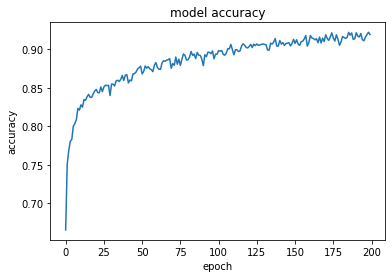

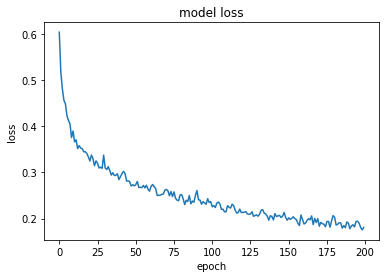

In [ ]:
# history = model.fit(X, Y, validation_split=0.33, epochs=150, batch_size=10, verbose=0)
Adam_acc_list = []
Adam_loss_list = []
# list all data in history
print(history.history.keys())
# summarize history for accuracy
Adam_acc_list = history.history['accuracy'] 
Adam_loss_list = history.history['loss'] 
plt.plot(history.history['accuracy'])
# plt.plot(history.history['])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
Adam_acc_list = pd.DataFrame(Adam_acc_list)
Adam_acc_list.to_csv('cen_Adam_acc_list.csv')
Adam_loss_list = pd.DataFrame(Adam_loss_list)
Adam_loss_list.to_csv('cen_Adam_loss_list.csv')
# SGD_acc_list = history.history['accuracy'] 
# SGD_loss_list

## **RMSprop**

In [ ]:
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import RMSprop
lr = 0.01 
comms_round = 100
loss='sparse_categorical_crossentropy'
metrics = ['accuracy']
optimizer = RMSprop(learning_rate=lr, 
                decay=lr / comms_round, 
                momentum=0.9
               )   

In [ ]:
# from tensorflow.keras.optimizers import RMSprop
# # from tensorflow.keras.optimizers.schedules import ExponentialDecay
# lr = 0.01 
# comms_round = 100
# loss='sparse_categorical_crossentropy'
# metrics = ['accuracy']
# # lr_schedule = ExponentialDecay(
# #     initial_learning_rate=0.01,
# #     decay_steps=10000,
# #     decay_rate=lr / comms_round)
# # tf.keras.optimizers.RMSprop(
# #     learning_rate=0.001, rho=0.9, momentum=0.0, epsilon=1e-07, centered=False,
# #     name='RMSprop', **kwargs
# # )
# optimizer = RMSprop(learning_rate=lr, 
#                 decay=lr / comms_round, 
#                 momentum=0.9
#                )  
# optimizer = Adam(learning_rate = lr_schedule)


SGD_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(len(y_train)).batch(320)
smlp_SGD = SimpleMLP()
SGD_model = smlp_SGD.build(15, 2) 
SGD_model.compile(loss=loss, 
              optimizer=optimizer, 
              metrics=metrics)
history = SGD_model.fit(SGD_dataset, epochs=200, verbose=1)
for(X_test, Y_test) in test_batched:
        SGD_acc, SGD_loss = test_model(X_test, Y_test, SGD_model, 1)

Epoch 1/200
21/21 [==============================] - 0s 3ms/step - loss: 1.0021 - accuracy: 0.5366
Epoch 2/200
21/21 [==============================] - 0s 3ms/step - loss: 0.6070 - accuracy: 0.6586
Epoch 3/200
21/21 [==============================] - 0s 3ms/step - loss: 0.5744 - accuracy: 0.6972
Epoch 4/200
21/21 [==============================] - 0s 3ms/step - loss: 0.5516 - accuracy: 0.7163
Epoch 5/200
21/21 [==============================] - 0s 3ms/step - loss: 0.5266 - accuracy: 0.7422
Epoch 6/200
21/21 [==============================] - 0s 3ms/step - loss: 0.5232 - accuracy: 0.7385
Epoch 7/200
21/21 [==============================] - 0s 3ms/step - loss: 0.5099 - accuracy: 0.7514
Epoch 8/200
21/21 [==============================] - 0s 3ms/step - loss: 0.5071 - accuracy: 0.7551
Epoch 9/200
21/21 [==============================] - 0s 2ms/step - loss: 0.4889 - accuracy: 0.7703
Epoch 10/200
21/21 [==============================] - 0s 2ms/step - loss: 0.4836 - accuracy: 0.7697
Epoch 11/

dict_keys(['loss', 'accuracy'])


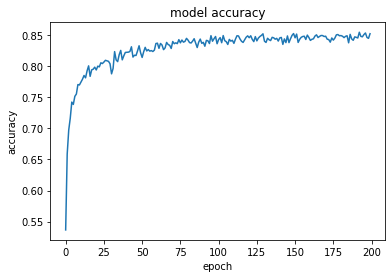

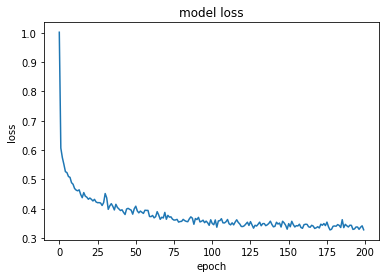

In [ ]:
# history = model.fit(X, Y, validation_split=0.33, epochs=150, batch_size=10, verbose=0)
RMS_acc_list = []
RMS_loss_list = []
# list all data in history
print(history.history.keys())
# summarize history for accuracy
RMS_acc_list = history.history['accuracy'] 
RMS_loss_list = history.history['loss'] 
plt.plot(history.history['accuracy'])
# plt.plot(history.history['])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
RMS_acc_list = pd.DataFrame(RMS_acc_list)
RMS_acc_list.to_csv('cen_RMS_acc_list.csv')
RMS_loss_list = pd.DataFrame(RMS_loss_list)
RMS_loss_list.to_csv('cen_RMS_loss_list.csv')
# SGD_acc_list = history.history['accuracy'] 
# SGD_loss_list

## **ADADELTA**

In [ ]:
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import Adadelta
lr = 0.01 
comms_round = 100
loss='sparse_categorical_crossentropy'
metrics = ['accuracy']
optimizer = Adadelta(learning_rate=lr, 
                decay=lr / comms_round
               )    

In [ ]:
# from tensorflow.keras.optimizers import Adadelta
# # from tensorflow.keras.optimizers.schedules import ExponentialDecay
# lr = 0.01 
# comms_round = 100
# loss='sparse_categorical_crossentropy'
# metrics = ['accuracy']
# lr_schedule = ExponentialDecay(
#     initial_learning_rate=0.01,
#     decay_steps=10000,
#     decay_rate=lr / comms_round)
# # tf.keras.optimizers.RMSprop(
# #     learning_rate=0.001, rho=0.9, momentum=0.0, epsilon=1e-07, centered=False,
# #     name='RMSprop', **kwargs
# # )
# optimizer = Adadelta(learning_rate=lr_schedule) 
# optimizer = Adam(learning_rate = lr_schedule)


SGD_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(len(y_train)).batch(320)
smlp_SGD = SimpleMLP()
SGD_model = smlp_SGD.build(15, 2) 
SGD_model.compile(loss=loss, 
              optimizer=optimizer, 
              metrics=metrics)
history = SGD_model.fit(SGD_dataset, epochs=200, verbose=1)
for(X_test, Y_test) in test_batched:
        SGD_acc, SGD_loss = test_model(X_test, Y_test, SGD_model, 1)

Epoch 1/200
21/21 [==============================] - 1s 7ms/step - loss: 0.6992 - accuracy: 0.4672
Epoch 2/200
21/21 [==============================] - 0s 6ms/step - loss: 0.6968 - accuracy: 0.4653
Epoch 3/200
21/21 [==============================] - 0s 6ms/step - loss: 0.6946 - accuracy: 0.4625
Epoch 4/200
21/21 [==============================] - 0s 6ms/step - loss: 0.6925 - accuracy: 0.4710
Epoch 5/200
21/21 [==============================] - 0s 6ms/step - loss: 0.6906 - accuracy: 0.4821
Epoch 6/200
21/21 [==============================] - 0s 7ms/step - loss: 0.6887 - accuracy: 0.5021
Epoch 7/200
21/21 [==============================] - 0s 6ms/step - loss: 0.6869 - accuracy: 0.5217
Epoch 8/200
21/21 [==============================] - 0s 6ms/step - loss: 0.6852 - accuracy: 0.5374
Epoch 9/200
21/21 [==============================] - 0s 6ms/step - loss: 0.6836 - accuracy: 0.5523
Epoch 10/200
21/21 [==============================] - 0s 6ms/step - loss: 0.6820 - accuracy: 0.5618
Epoch 11/

dict_keys(['loss', 'accuracy'])


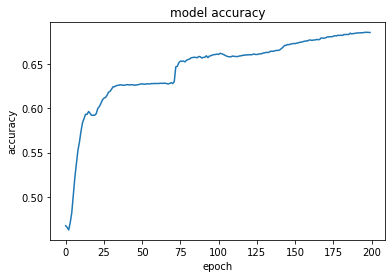

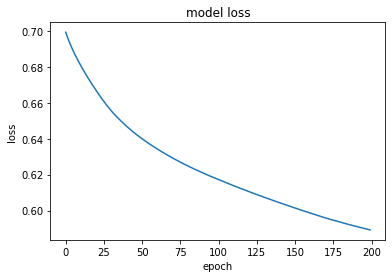

In [ ]:
# history = model.fit(X, Y, validation_split=0.33, epochs=150, batch_size=10, verbose=0)
Adadelta_acc_list = []
Adadelta_loss_list = []
# list all data in history
print(history.history.keys())
# summarize history for accuracy
Adadelta_acc_list = history.history['accuracy'] 
Adadelta_loss_list = history.history['loss'] 
plt.plot(history.history['accuracy'])
# plt.plot(history.history['])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
Adadelta_acc_list = pd.DataFrame(Adadelta_acc_list)
Adadelta_acc_list.to_csv('cen_Adadelta_acc_list.csv')
Adadelta_loss_list = pd.DataFrame(Adadelta_loss_list)
Adadelta_loss_list.to_csv('cen_Adadelta_loss_list.csv')

## **ADAMAX**

In [ ]:
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import Adamax
lr = 0.01 
comms_round = 100
loss='sparse_categorical_crossentropy'
metrics = ['accuracy']
optimizer = Adamax(learning_rate=lr, 
                decay=lr / comms_round
               )    

In [ ]:
# from tensorflow.keras.optimizers import Adamax
# # from tensorflow.keras.optimizers.schedules import ExponentialDecay
# lr = 0.01 
# comms_round = 100
# loss='sparse_categorical_crossentropy'
# metrics = ['accuracy']
# lr_schedule = ExponentialDecay(
#     initial_learning_rate=0.01,
#     decay_steps=10000,
#     decay_rate=lr / comms_round)
# # tf.keras.optimizers.Ftrl(
# #     learning_rate=0.001, rho=0.9, momentum=0.0, epsilon=1e-07, centered=False,
# #     name='RMSprop', **kwargs
# # )
# optimizer = Adamax(learning_rate=lr_schedule) 
# # optimizer = Adam(learning_rate = lr_schedule)


SGD_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(len(y_train)).batch(320)
smlp_SGD = SimpleMLP()
SGD_model = smlp_SGD.build(15, 2) 
SGD_model.compile(loss=loss, 
              optimizer=optimizer, 
              metrics=metrics)
history = SGD_model.fit(SGD_dataset, epochs=200, verbose=1)
for(X_test, Y_test) in test_batched:
        SGD_acc, SGD_loss = test_model(X_test, Y_test, SGD_model, 1)

Epoch 1/200
21/21 [==============================] - 1s 8ms/step - loss: 0.6219 - accuracy: 0.6452
Epoch 2/200
21/21 [==============================] - 0s 8ms/step - loss: 0.5368 - accuracy: 0.7328
Epoch 3/200
21/21 [==============================] - 0s 9ms/step - loss: 0.4936 - accuracy: 0.7626
Epoch 4/200
21/21 [==============================] - 0s 8ms/step - loss: 0.4694 - accuracy: 0.7754
Epoch 5/200
21/21 [==============================] - 0s 9ms/step - loss: 0.4564 - accuracy: 0.7773
Epoch 6/200
21/21 [==============================] - 0s 9ms/step - loss: 0.4412 - accuracy: 0.7861
Epoch 7/200
21/21 [==============================] - 0s 8ms/step - loss: 0.4239 - accuracy: 0.7985
Epoch 8/200
21/21 [==============================] - 0s 9ms/step - loss: 0.4025 - accuracy: 0.8155
Epoch 9/200
21/21 [==============================] - 0s 8ms/step - loss: 0.3916 - accuracy: 0.8192
Epoch 10/200
21/21 [==============================] - 0s 7ms/step - loss: 0.3892 - accuracy: 0.8149
Epoch 11/

dict_keys(['loss', 'accuracy'])


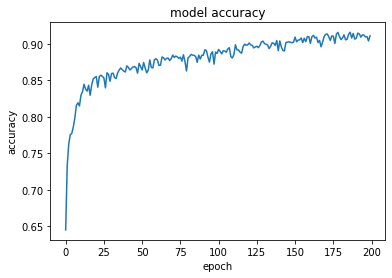

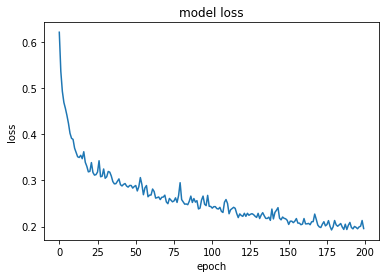

In [ ]:
# history = model.fit(X, Y, validation_split=0.33, epochs=150, batch_size=10, verbose=0)
Adamax_acc_list = []
Adamax_loss_list = []
# list all data in history
print(history.history.keys())
# summarize history for accuracy
Adamax_acc_list = history.history['accuracy'] 
Adamax_loss_list = history.history['loss'] 
plt.plot(history.history['accuracy'])
# plt.plot(history.history['])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
Adamax_acc_list = pd.DataFrame(Adamax_acc_list)
Adamax_acc_list.to_csv('cen_Adamax_acc_list.csv')
Adamax_loss_list = pd.DataFrame(Adamax_loss_list)
Adamax_loss_list.to_csv('cen_Adamax_loss_list.csv')

## **Adagrad**

In [ ]:
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import Adagrad
lr = 0.01 
comms_round = 100
loss='sparse_categorical_crossentropy'
metrics = ['accuracy']
optimizer = Adagrad(learning_rate=lr, 
                decay=lr / comms_round
               )    

In [ ]:

SGD_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(len(y_train)).batch(320)
smlp_SGD = SimpleMLP()
SGD_model = smlp_SGD.build(15, 2) 
SGD_model.compile(loss=loss, 
              optimizer=optimizer, 
              metrics=metrics)
history = SGD_model.fit(SGD_dataset, epochs=200, verbose=1)
for(X_test, Y_test) in test_batched:
        SGD_acc, SGD_loss = test_model(X_test, Y_test, SGD_model, 1)

Epoch 1/200
21/21 [==============================] - 1s 10ms/step - loss: 0.6879 - accuracy: 0.5731
Epoch 2/200
21/21 [==============================] - 0s 13ms/step - loss: 0.6749 - accuracy: 0.6419
Epoch 3/200
21/21 [==============================] - 0s 10ms/step - loss: 0.6651 - accuracy: 0.6306
Epoch 4/200
21/21 [==============================] - 0s 13ms/step - loss: 0.6570 - accuracy: 0.6288
Epoch 5/200
21/21 [==============================] - 0s 11ms/step - loss: 0.6504 - accuracy: 0.6306
Epoch 6/200
21/21 [==============================] - 0s 8ms/step - loss: 0.6446 - accuracy: 0.6317
Epoch 7/200
21/21 [==============================] - 0s 10ms/step - loss: 0.6394 - accuracy: 0.6317
Epoch 8/200
21/21 [==============================] - 0s 11ms/step - loss: 0.6346 - accuracy: 0.6311
Epoch 9/200
21/21 [==============================] - 0s 10ms/step - loss: 0.6302 - accuracy: 0.6317
Epoch 10/200
21/21 [==============================] - 0s 12ms/step - loss: 0.6262 - accuracy: 0.6326


dict_keys(['loss', 'accuracy'])


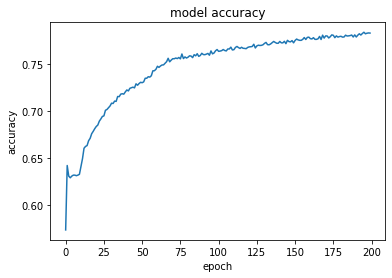

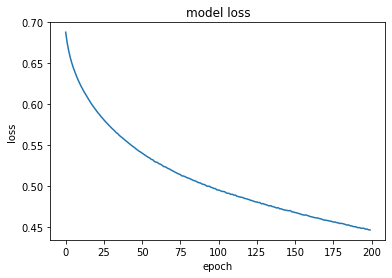

In [ ]:
# history = model.fit(X, Y, validation_split=0.33, epochs=150, batch_size=10, verbose=0)
Adagrad_acc_list = []
Adagrad_loss_list = []
# list all data in history
print(history.history.keys())
# summarize history for accuracy
Adagrad_acc_list = history.history['accuracy'] 
Adagrad_loss_list = history.history['loss'] 
plt.plot(history.history['accuracy'])
# plt.plot(history.history['])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
Adagrad_acc_list = pd.DataFrame(Adagrad_acc_list)
Adagrad_acc_list.to_csv('cen_Adagrad_acc_list.csv')
Adagrad_loss_list = pd.DataFrame(Adagrad_loss_list)
Adagrad_loss_list.to_csv('cen_Adagrad_loss_list.csv')

# **PLOTS**

## **SGD**

In [ ]:
acc_fl = pd.read_csv('/content/acc_global_SGD.csv')
acc_cen = pd.read_csv('/content/cen_SGD_acc_list.csv')

loss_fl = pd.read_csv('/content/loss_global_SGD.csv')
loss_cen = pd.read_csv('/content/cen_SGD_loss_list.csv')

In [ ]:
acc_fl.drop(['Unnamed: 0'],axis=1,inplace=True)
acc_cen.drop(['Unnamed: 0'],axis=1,inplace=True)
loss_fl.drop(['Unnamed: 0'],axis=1,inplace=True)
loss_cen.drop(['Unnamed: 0'],axis=1,inplace=True)

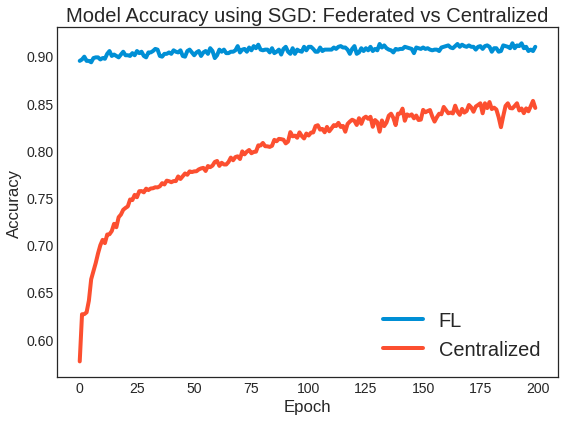

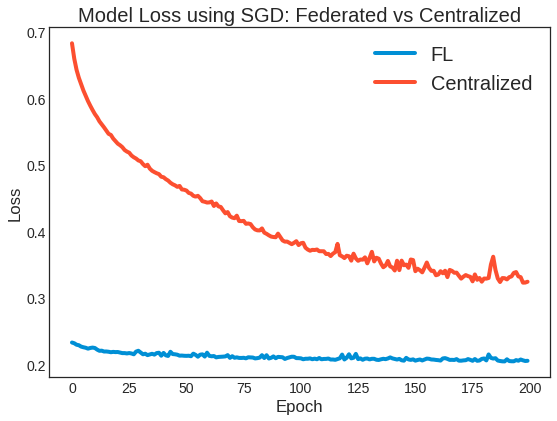

In [ ]:
from matplotlib import style

# plt.style.use('ggplot')
plt.style.use('fivethirtyeight')
plt.style.use('seaborn-white')
plt.figure(figsize=(8,6))
plt.plot(acc_fl)
plt.plot(acc_cen)
plt.title('Model Accuracy using SGD: Federated vs Centralized')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
# plt.legend(fontsize=20)
plt.legend(['FL', 'Centralized'],fontsize=20)
plt.savefig('1-1.png', bbox_inches='tight')

plt.show()

plt.figure(figsize=(8,6))
plt.plot(loss_fl)
plt.plot(loss_cen)
plt.title('Model Loss using SGD: Federated vs Centralized')
plt.ylabel('Loss')
plt.xlabel('Epoch')
# plt.legend(fontsize=20)
plt.legend(['FL', 'Centralized'],fontsize=20)
plt.savefig('1-2.png', bbox_inches='tight')
plt.show()

## **RMSprop**

In [ ]:
acc_fl = pd.read_csv('/content/acc_global_rmsprop.csv')
acc_cen = pd.read_csv('/content/cen_RMS_acc_list.csv')
loss_fl = pd.read_csv('/content/loss_global_rmsprop.csv')
loss_cen = pd.read_csv('/content/cen_RMS_loss_list.csv')

In [ ]:
acc_fl.drop(['Unnamed: 0'],axis=1,inplace=True)
acc_cen.drop(['Unnamed: 0'],axis=1,inplace=True)
loss_fl.drop(['Unnamed: 0'],axis=1,inplace=True)
loss_cen.drop(['Unnamed: 0'],axis=1,inplace=True)

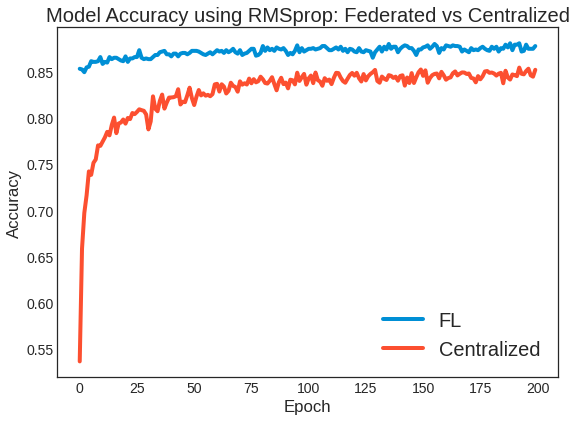

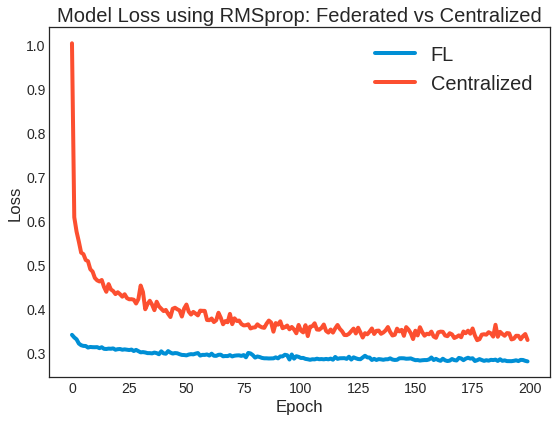

In [ ]:
from matplotlib import style
# plt.style.use('ggplot')
plt.figure(figsize=(8,6))
plt.plot(acc_fl)
plt.plot(acc_cen)
plt.title('Model Accuracy using RMSprop: Federated vs Centralized')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
# plt.legend()
plt.legend(['FL', 'Centralized'],fontsize=20)
plt.savefig('2-1.png', bbox_inches='tight')
plt.show()

plt.figure(figsize=(8,6))
plt.plot(loss_fl)
plt.plot(loss_cen)
plt.title('Model Loss using RMSprop: Federated vs Centralized')
plt.ylabel('Loss')
plt.xlabel('Epoch')
# plt.legend()
plt.legend(['FL', 'Centralized'],fontsize=20)
plt.savefig('2-2.png', bbox_inches='tight')
plt.show()

## **ADAMAX**

In [ ]:
acc_fl = pd.read_csv('/content/acc_global_adamax.csv')
acc_cen = pd.read_csv('/content/cen_Adamax_acc_list.csv')
loss_fl = pd.read_csv('/content/loss_global_adamax.csv')
loss_cen = pd.read_csv('/content/cen_Adamax_loss_list.csv')

In [ ]:
acc_fl.drop(['Unnamed: 0'],axis=1,inplace=True)
acc_cen.drop(['Unnamed: 0'],axis=1,inplace=True)
loss_fl.drop(['Unnamed: 0'],axis=1,inplace=True)
loss_cen.drop(['Unnamed: 0'],axis=1,inplace=True)

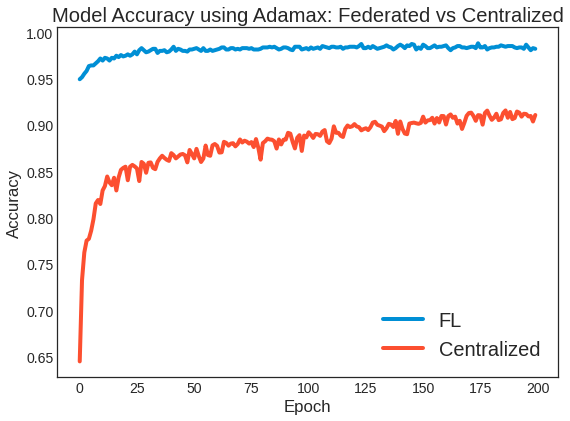

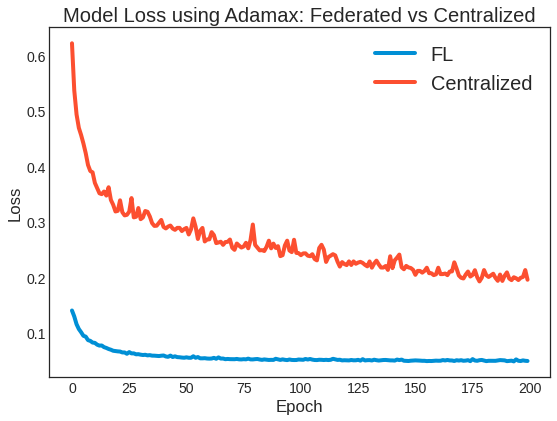

In [ ]:
# from matplotlib import style
# plt.style.use('ggplot')
plt.figure(figsize=(8,6))
plt.plot(acc_fl)
plt.plot(acc_cen)
plt.title('Model Accuracy using Adamax: Federated vs Centralized')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
# plt.legend()
plt.legend(['FL', 'Centralized'],fontsize=20)
plt.savefig('3-1.png', bbox_inches='tight')
plt.show()

plt.figure(figsize=(8,6))
plt.plot(loss_fl)
plt.plot(loss_cen)
plt.title('Model Loss using Adamax: Federated vs Centralized')
plt.ylabel('Loss')
plt.xlabel('Epoch')
# plt.legend()
plt.legend(['FL', 'Centralized'],fontsize=20)
plt.savefig('3-2.png', bbox_inches='tight')
plt.show()

## **Adam**

In [ ]:
acc_fl = pd.read_csv('/content/acc_global_adam.csv')
acc_cen = pd.read_csv('/content/cen_Adam_acc_list.csv')
loss_fl = pd.read_csv('/content/loss_global_adam.csv')
loss_cen = pd.read_csv('/content/cen_Adam_loss_list.csv')

In [ ]:
acc_fl.drop(['Unnamed: 0'],axis=1,inplace=True)
acc_cen.drop(['Unnamed: 0'],axis=1,inplace=True)
loss_fl.drop(['Unnamed: 0'],axis=1,inplace=True)
loss_cen.drop(['Unnamed: 0'],axis=1,inplace=True)

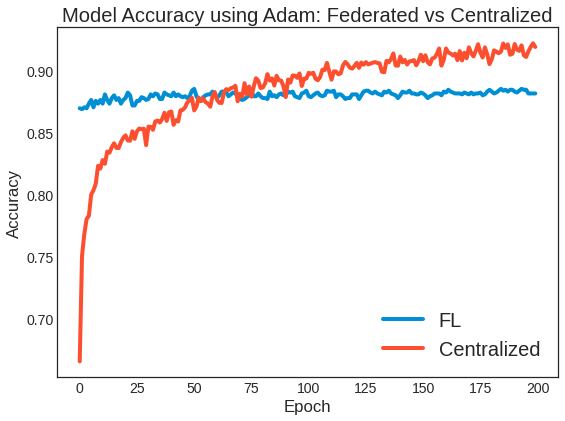

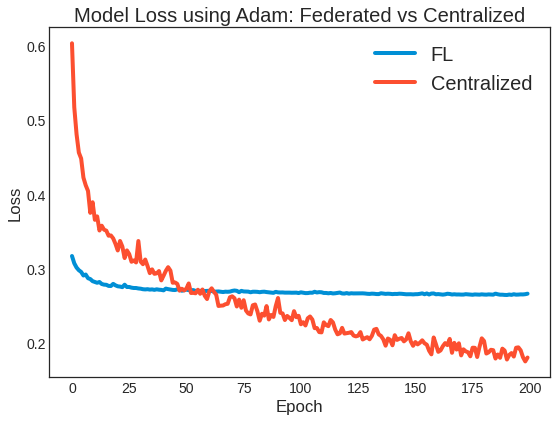

In [ ]:
from matplotlib import style
# plt.style.use('ggplot')
plt.figure(figsize=(8,6))
plt.plot(acc_fl)
plt.plot(acc_cen)
plt.title('Model Accuracy using Adam: Federated vs Centralized')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
# plt.legend()
plt.legend(['FL', 'Centralized'],fontsize=20)
plt.savefig('4-1.png', bbox_inches='tight')
plt.show()

plt.figure(figsize=(8,6))
plt.plot(loss_fl)
plt.plot(loss_cen)
plt.title('Model Loss using Adam: Federated vs Centralized')
plt.ylabel('Loss')
plt.xlabel('Epoch')
# plt.legend()
plt.legend(['FL', 'Centralized'],fontsize=20)
plt.savefig('4-2.png', bbox_inches='tight')
plt.show()

## **Adagrad**

In [ ]:
acc_fl = pd.read_csv('/content/acc_global_adagrad.csv')
acc_cen = pd.read_csv('/content/cen_Adagrad_acc_list.csv')
loss_fl = pd.read_csv('/content/loss_global_adagrad.csv')
loss_cen = pd.read_csv('/content/cen_Adagrad_loss_list.csv')

In [ ]:
acc_fl.drop(['Unnamed: 0'],axis=1,inplace=True)
acc_cen.drop(['Unnamed: 0'],axis=1,inplace=True)
loss_fl.drop(['Unnamed: 0'],axis=1,inplace=True)
loss_cen.drop(['Unnamed: 0'],axis=1,inplace=True)

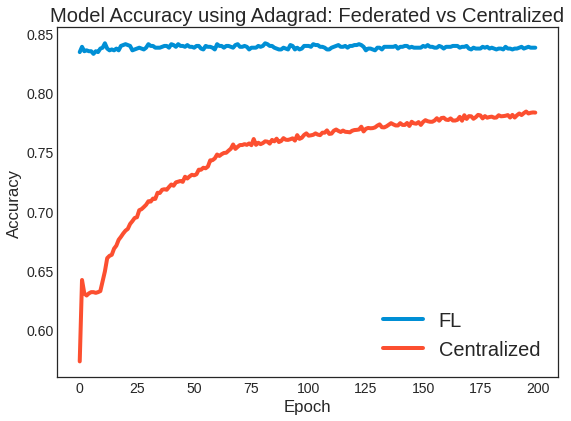

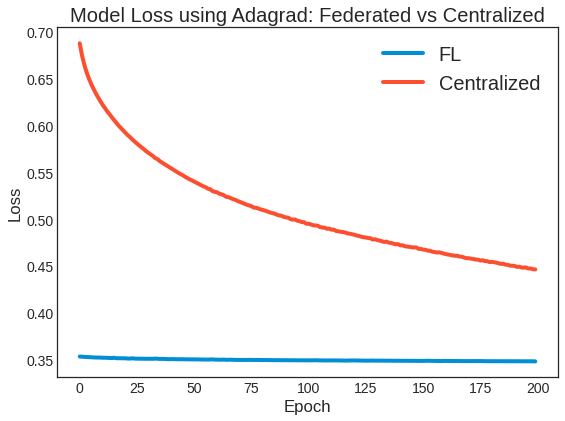

In [ ]:
from matplotlib import style
# plt.style.use('ggplot')
plt.figure(figsize=(8,6))
plt.plot(acc_fl)
plt.plot(acc_cen)
plt.title('Model Accuracy using Adagrad: Federated vs Centralized')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
# plt.legend()
plt.legend(['FL', 'Centralized'],fontsize=20)
plt.savefig('5-1.png', bbox_inches='tight')
plt.show()

plt.figure(figsize=(8,6))
plt.plot(loss_fl)
plt.plot(loss_cen)
plt.title('Model Loss using Adagrad: Federated vs Centralized')
plt.ylabel('Loss')
plt.xlabel('Epoch')
# plt.legend()
plt.legend(['FL', 'Centralized'],fontsize=20)
plt.savefig('5-2.png', bbox_inches='tight')
plt.show()

## **Adadelta**

In [ ]:
acc_fl = pd.read_csv('/content/acc_global_adadelta.csv')
acc_cen = pd.read_csv('/content/cen_Adadelta_acc_list.csv')
loss_fl = pd.read_csv('/content/loss_global_adadelta.csv')
loss_cen = pd.read_csv('/content/cen_Adadelta_loss_list.csv')

In [ ]:
acc_fl.drop(['Unnamed: 0'],axis=1,inplace=True)
acc_cen.drop(['Unnamed: 0'],axis=1,inplace=True)
loss_fl.drop(['Unnamed: 0'],axis=1,inplace=True)
loss_cen.drop(['Unnamed: 0'],axis=1,inplace=True)

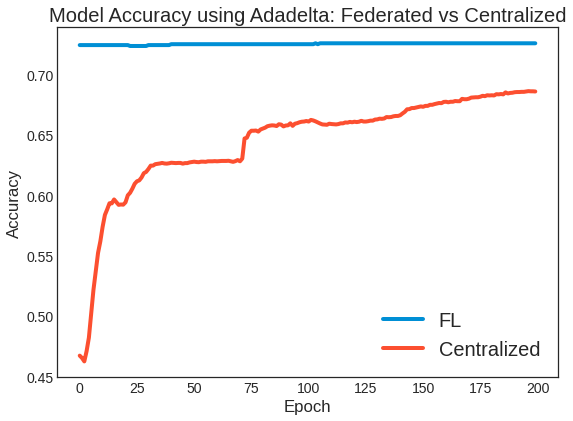

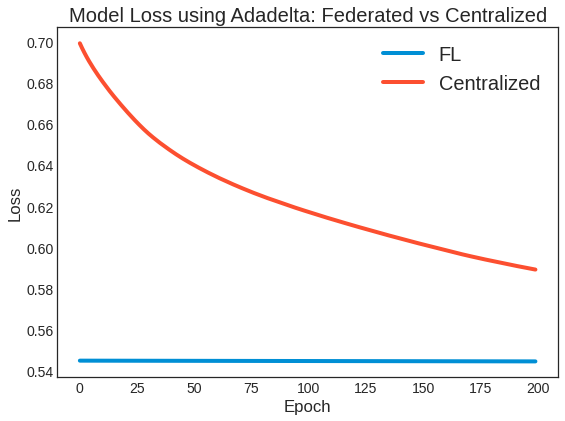

In [ ]:
from matplotlib import style
# plt.style.use('ggplot')
plt.figure(figsize=(8,6))
plt.plot(acc_fl)
plt.plot(acc_cen)
plt.title('Model Accuracy using Adadelta: Federated vs Centralized')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
# plt.legend()
plt.legend(['FL', 'Centralized'],fontsize=20)
plt.savefig('6-1.png', bbox_inches='tight')
plt.show()

plt.figure(figsize=(8,6))
plt.plot(loss_fl)
plt.plot(loss_cen)
plt.title('Model Loss using Adadelta: Federated vs Centralized')
plt.ylabel('Loss')
plt.xlabel('Epoch')
# plt.legend()
plt.legend(['FL', 'Centralized'],fontsize=20)
plt.savefig('6-2.png', bbox_inches='tight')
plt.show()

# **FL Global Model**

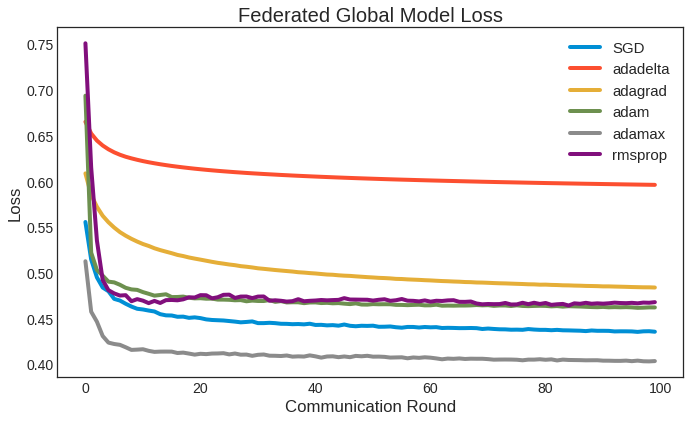

In [ ]:
loss_adadelta = pd.read_csv('/content/global_model_loss_adadelta.csv')
loss_adagrad = pd.read_csv('/content/global_model_loss_adagrad.csv')
loss_adam = pd.read_csv('/content/global_model_loss_adam.csv')
loss_adamax = pd.read_csv('/content/global_model_loss_adamax.csv')
loss_rmsprop = pd.read_csv('/content/global_model_loss_rmsprop.csv')
loss_sgd = pd.read_csv('/content/global_model_loss_SGD.csv')

loss_adadelta.drop(['Unnamed: 0'],axis=1,inplace=True)
loss_adagrad.drop(['Unnamed: 0'],axis=1,inplace=True)
loss_adam.drop(['Unnamed: 0'],axis=1,inplace=True)
loss_adamax.drop(['Unnamed: 0'],axis=1,inplace=True)
loss_rmsprop.drop(['Unnamed: 0'],axis=1,inplace=True)
loss_sgd.drop(['Unnamed: 0'],axis=1,inplace=True)

plt.figure(figsize=(10,6))
plt.plot(loss_sgd)
plt.plot(loss_adadelta)
plt.plot(loss_adagrad)
plt.plot(loss_adam)
plt.plot(loss_adamax)
plt.plot(loss_rmsprop)
# plt.plot(history.history['])
plt.title('Federated Global Model Loss')
plt.ylabel('Loss')
plt.xlabel('Communication Round')
# plt.legend()
plt.legend(['SGD','adadelta', 'adagrad','adam','adamax','rmsprop'],fontsize=15)
plt.savefig('FL_loss.png', bbox_inches='tight')
plt.show()

In [ ]:
# plt.plot(SGD_loss_list)
# plt.plot(Adam_loss_list)
# plt.plot(RMS_loss_list)
# plt.plot(Adadelta_loss_list)
# plt.plot(Adamax_loss_list)
# # plt.plot(history.history['])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend()
# plt.legend(['SGD', 'ADAM','RMS','ADADELTA','ADAMAX'])
# plt.show()